In [49]:
# ============================================================================
# CELL 1: Imports and Configuration
# ============================================================================
"""
Dynamic Portfolio Optimization with PPO - Padding Version
Supports ANY portfolio size (3-100 assets) via padding
Date: November 25, 2025
"""

import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

import yfinance as yf
import torch
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.callbacks import CheckpointCallback
import gymnasium as gym
from gymnasium import spaces

import os
import json
from typing import List, Dict, Tuple, Optional
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("=" * 80)
print("DYNAMIC PORTFOLIO OPTIMIZATION WITH PPO - PADDING VERSION")
print("=" * 80)
print(f"\n✅ All libraries imported")
print(f"   PyTorch: {torch.__version__}\n")

CONFIG = {
    'total_timesteps': 500000,
    'n_steps': 2048,
    'batch_size': 64,
    'learning_rate': 0.0003,
    'n_epochs': 10,
    'gamma': 0.99,
    'gae_lambda': 0.95,
    'clip_range': 0.2,
    
    'initial_capital': 100000,
    'commission': 0.001,
    'max_position_size': 0.15,
    'min_position_size': 0.01,
    
    'start_date': datetime(2022, 1, 1),
    'end_date': datetime(2023, 12, 31),
    'lookback_days': 252,
    
    'tickers': [
        'AAPL', 'MSFT', 'GOOGL', 'AMZN', 'META', 'NVDA', 'TSLA', 'AVGO', 'ORCL', 'CRM',
        'JPM', 'BAC', 'WFC', 'GS', 'MS', 'BLK', 'SCHW', 'AXP', 'C', 'USB',
        'UNH', 'JNJ', 'LLY', 'ABBV', 'MRK', 'TMO', 'ABT', 'DHR', 'PFE', 'BMY',
        'WMT', 'HD', 'MCD', 'NKE', 'SBUX', 'TGT', 'LOW', 'COST', 'TJX', 'DG',
        'CAT', 'BA', 'HON', 'UNP', 'RTX', 'XOM', 'CVX', 'COP', 'SLB', 'EOG',
        'LIN', 'APD', 'NEE', 'DUK', 'SO'
    ],
    
    'max_assets': 100,
    'model_dir': 'models',
    'model_name': 'ppo_dynamic_portfolio_padded',
    'tensorboard_log': './ppo_dynamic_tensorboard/',
}

os.makedirs(CONFIG['model_dir'], exist_ok=True)
os.makedirs(CONFIG['tensorboard_log'], exist_ok=True)

print("📋 CONFIGURATION")
print("-" * 80)
print(f"Training Assets:     {len(CONFIG['tickers'])}")
print(f"Max Supported:       {CONFIG['max_assets']}")
print(f"Observation Space:   {CONFIG['max_assets'] + 14} features")
print(f"\n🎯 Model will work with 3-{CONFIG['max_assets']} assets!")
print("=" * 80)


DYNAMIC PORTFOLIO OPTIMIZATION WITH PPO - PADDING VERSION

✅ All libraries imported
   PyTorch: 2.9.1

📋 CONFIGURATION
--------------------------------------------------------------------------------
Training Assets:     55
Max Supported:       100
Observation Space:   114 features

🎯 Model will work with 3-100 assets!


In [50]:
# ============================================================================
# CELL 2: Dynamic Feature Engineering with Padding (FIXED)
# ============================================================================

class DynamicFeatureEngineer:
    """Feature engineering with padding for variable-size portfolios"""
    
    def __init__(self, num_assets: int, max_assets: int = 100):
        self.num_assets = num_assets
        self.max_assets = max_assets
        self.obs_dim = max_assets + 14
        print(f"   Feature Engineer: {num_assets} assets → {self.obs_dim} features")
        
    def get_observation_space(self) -> spaces.Box:
        return spaces.Box(low=-np.inf, high=np.inf, shape=(self.obs_dim,), dtype=np.float32)
    
    def get_features(self, data: pd.DataFrame, current_idx: int) -> np.ndarray:
        features = []
        
        # 1. Asset returns with padding
        returns = data.pct_change()
        for ticker in data.columns:
            ret = returns[ticker].iloc[current_idx]
            features.append(ret if not np.isnan(ret) else 0.0)
        
        # Pad with zeros
        features.extend([0.0] * (self.max_assets - len(data.columns)))
        
        # 2. Volatility features (10)
        features.extend(self._calculate_volatility_features(data, current_idx))
        
        # 3. Correlation features (4)
        features.extend(self._calculate_correlation_features(data, current_idx))
        
        return np.array(features, dtype=np.float32)
    
    def _calculate_volatility_features(self, data: pd.DataFrame, idx: int) -> List[float]:
        returns = data.pct_change().iloc[:idx+1]
        if len(returns) < 5:
            return [0.0] * 10
        try:
            features = [
                returns.std(axis=1).iloc[-5:].mean() if len(returns) >= 5 else 0.0,
                returns.std(axis=1).iloc[-20:].mean() if len(returns) >= 20 else 0.0,
                returns.std(axis=1).iloc[-60:].mean() if len(returns) >= 60 else 0.0,
                returns.std().mean(),
                returns.std().std(),
                returns.skew().mean(),
                returns.kurtosis().mean(),
                (returns > 0).mean().mean(),
                returns.max(axis=1).iloc[-20:].mean() if len(returns) >= 20 else 0.0,
                returns.min(axis=1).iloc[-20:].mean() if len(returns) >= 20 else 0.0,
            ]
            return [f if np.isfinite(f) else 0.0 for f in features]
        except:
            return [0.0] * 10
    
    def _calculate_correlation_features(self, data: pd.DataFrame, idx: int) -> List[float]:
        returns = data.pct_change().iloc[max(0, idx-60):idx+1]
        if len(returns) < 20 or len(data.columns) < 2:
            return [0.0] * 4
        try:
            corr_matrix = returns.corr()
            np.fill_diagonal(corr_matrix.values, np.nan)
            features = [
                corr_matrix.mean().mean(),
                corr_matrix.std().std(),
                corr_matrix.max().max(),
                corr_matrix.min().min(),
            ]
            return [f if np.isfinite(f) else 0.0 for f in features]
        except:
            return [0.0] * 4

print("\n🧪 Testing Feature Engineering...")
print("-" * 80)
for n in [5, 10, 25, 55, 100]:
    DynamicFeatureEngineer(num_assets=n, max_assets=CONFIG['max_assets'])
print(f"\n✅ All portfolios → {CONFIG['max_assets'] + 14} features")
print("=" * 80)



🧪 Testing Feature Engineering...
--------------------------------------------------------------------------------
   Feature Engineer: 5 assets → 114 features
   Feature Engineer: 10 assets → 114 features
   Feature Engineer: 25 assets → 114 features
   Feature Engineer: 55 assets → 114 features
   Feature Engineer: 100 assets → 114 features

✅ All portfolios → 114 features


In [51]:
# ============================================================================
# CELL 3: Dynamic Portfolio Environment (WITH PADDING, ACTION TRIMMING FIX)
# ============================================================================

class DynamicPortfolioEnv(gym.Env):
    """Portfolio environment supporting 3-100 assets via padding/trimming."""

    metadata = {'render_modes': ['human']}
    
    def __init__(self, tickers: List[str], data: pd.DataFrame, initial_capital: float = 100000,
                 commission: float = 0.001, max_position_size: float = 0.15,
                 min_position_size: float = 0.01, max_assets: int = 100):
        super().__init__()
        
        self.tickers = tickers
        self.num_assets = len(tickers)
        self.data = data
        self.initial_capital = initial_capital
        self.commission = commission
        self.max_position_size = max_position_size
        self.min_position_size = min_position_size
        self.max_assets = max_assets
        
        self.feature_engineer = DynamicFeatureEngineer(self.num_assets, self.max_assets)
        
        # Action space: only for ACTUAL assets (not padded)
        self.action_space = spaces.Box(low=0, high=1, shape=(self.num_assets,), dtype=np.float32)
        # Observation space: always padded
        self.observation_space = self.feature_engineer.get_observation_space()
        
        self.current_step = 0
        self.max_steps = len(data) - 1
        self.portfolio_value = initial_capital
        self.cash = initial_capital
        self.holdings = np.zeros(self.num_assets)
        self.portfolio_history = []
        
        print(f"   Environment: {self.num_assets} assets, obs {self.observation_space.shape}")
        
    def reset(self, seed: Optional[int] = None, options: Optional[Dict] = None):
        super().reset(seed=seed)
        self.current_step = 60
        self.portfolio_value = self.initial_capital
        self.cash = self.initial_capital
        self.holdings = np.zeros(self.num_assets)
        self.portfolio_history = []
        return self._get_observation(), {}
    
    def _get_observation(self) -> np.ndarray:
        return self.feature_engineer.get_features(self.data, self.current_step)
    
    def step(self, action: np.ndarray):
        # ⭐ CRITICAL FIX: Trim action to only actual assets (ignore padded actions)
        action = action[:self.num_assets]

        action = np.abs(action)
        if action.sum() > 0:
            action = action / action.sum()
        else:
            action = np.ones(self.num_assets) / self.num_assets
        
        action = np.clip(action, self.min_position_size, self.max_position_size)
        action = action / action.sum()
        
        current_prices = self.data.iloc[self.current_step].values
        target_shares = (self.portfolio_value * action) / (current_prices + 1e-10)
        trades = target_shares - self.holdings
        commission_cost = np.abs(trades * current_prices).sum() * self.commission
        
        self.holdings = target_shares
        self.cash = self.portfolio_value - (self.holdings * current_prices).sum() - commission_cost
        self.current_step += 1
        
        if self.current_step < len(self.data):
            new_prices = self.data.iloc[self.current_step].values
            self.portfolio_value = self.cash + (self.holdings * new_prices).sum()
        
        reward = np.log(self.portfolio_value / self.portfolio_history[-1]) if self.portfolio_history else 0.0
        self.portfolio_history.append(self.portfolio_value)
        
        done = self.current_step >= self.max_steps - 1
        obs = self._get_observation() if not done else np.zeros(self.observation_space.shape[0])
        
        return obs, reward, done, False, {'portfolio_value': self.portfolio_value, 'step': self.current_step}

print("\n✅ Dynamic Portfolio Environment created (with action shape fix)")
print("=" * 80)



✅ Dynamic Portfolio Environment created (with action shape fix)


In [52]:
# ============================================================================
# CELL 4: Load Training Data (BATCH DOWNLOAD)
# ============================================================================

def load_market_data_batch(tickers: List[str], start_date: datetime, end_date: datetime, lookback_days: int = 252):
    lookback_start = start_date - timedelta(days=lookback_days + 30)
    
    print("\n📊 LOADING MARKET DATA (BATCH MODE)")
    print("-" * 80)
    print(f"Tickers: {len(tickers)}")
    print(f"Period: {lookback_start.date()} to {end_date.date()}")
    print("\nDownloading...\n")
    
    try:
        data = yf.download(tickers, start=lookback_start, end=end_date, group_by='column', auto_adjust=True, progress=True)
        
        if 'Close' in data.columns.get_level_values(0):
            close_data = data['Close']
        else:
            close_data = data
        
        if isinstance(close_data, pd.Series):
            close_data = close_data.to_frame(name=tickers[0])
        
        close_data = close_data.dropna()
        
        print("\n" + "=" * 80)
        print("✅ Data Loading Complete")
        print(f"   Downloaded: {len(close_data.columns)} assets")
        print(f"   Period: {close_data.index[0].date()} to {close_data.index[-1].date()}")
        print(f"   Trading Days: {len(close_data)}")
        print("=" * 80)
        
        return close_data
    except Exception as e:
        print(f"\n❌ ERROR: {e}")
        return pd.DataFrame()

training_data = load_market_data_batch(CONFIG['tickers'], CONFIG['start_date'], CONFIG['end_date'], CONFIG['lookback_days'])

if training_data.empty or len(training_data.columns) < 10:
    raise ValueError("Insufficient data loaded")

print("\n📋 Sample Data:")
print(training_data.head())
print(f"\nAssets: {list(training_data.columns)[:10]}...")


[******************    38%                       ]  21 of 55 completed


📊 LOADING MARKET DATA (BATCH MODE)
--------------------------------------------------------------------------------
Tickers: 55
Period: 2021-03-25 to 2023-12-31

Downloading...



[*********************100%***********************]  55 of 55 completed


✅ Data Loading Complete
   Downloaded: 55 assets
   Period: 2021-03-25 to 2023-12-29
   Trading Days: 697

📋 Sample Data:
Ticker            AAPL       ABBV         ABT        AMZN         APD  \
Date                                                                    
2021-03-25  117.564026  86.480469  109.207077  152.313004  246.737045   
2021-03-26  118.168457  88.228729  111.977386  152.601501  255.591309   
2021-03-29  118.343948  88.853111  112.124153  153.786499  252.699310   
2021-03-30  116.891350  88.903061  109.849205  152.764496  251.489059   
2021-03-31  119.084885  90.093529  109.931778  154.703995  251.694855   

Ticker           AVGO         AXP          BA        BAC         BLK  ...  \
Date                                                                  ...   
2021-03-25  41.939640  134.225479  247.190002  33.715714  652.264709  ...   
2021-03-26  43.787266  135.593430  244.869995  34.628887  678.624146  ...   
2021-03-29  42.931580  134.310379  250.520004  34.297630 

In [53]:
# ============================================================================
# CELL 5: Create Training Environment
# ============================================================================

print("\n🔧 CREATING TRAINING ENVIRONMENT")
print("=" * 80)

env = DynamicPortfolioEnv(
    tickers=list(training_data.columns),
    data=training_data,
    initial_capital=CONFIG['initial_capital'],
    commission=CONFIG['commission'],
    max_position_size=CONFIG['max_position_size'],
    min_position_size=CONFIG['min_position_size'],
    max_assets=CONFIG['max_assets']
)

env = DummyVecEnv([lambda: env])

print(f"\n✅ Environment Ready")
print(f"   Observation: {env.observation_space}")
print(f"   Action: {env.action_space}")
print("=" * 80)



🔧 CREATING TRAINING ENVIRONMENT
   Feature Engineer: 55 assets → 114 features
   Environment: 55 assets, obs (114,)

✅ Environment Ready
   Observation: Box(-inf, inf, (114,), float32)
   Action: Box(0.0, 1.0, (55,), float32)


In [54]:
# ============================================================================
# CELL 6: Initialize PPO Model
# ============================================================================

print("\n🤖 INITIALIZING PPO MODEL")
print("=" * 80)

model = PPO(
    'MlpPolicy',
    env,
    learning_rate=CONFIG['learning_rate'],
    n_steps=CONFIG['n_steps'],
    batch_size=CONFIG['batch_size'],
    n_epochs=CONFIG['n_epochs'],
    gamma=CONFIG['gamma'],
    gae_lambda=CONFIG['gae_lambda'],
    clip_range=CONFIG['clip_range'],
    verbose=1,
    tensorboard_log=CONFIG['tensorboard_log'],
    policy_kwargs=dict(
        net_arch=[dict(pi=[256, 256], vf=[256, 256])],
        activation_fn=torch.nn.ReLU
    )
)

print("\n✅ PPO Model Configured")
print(f"   Learning Rate: {CONFIG['learning_rate']}")
print(f"   Network: [256, 256] policy/value")
print("=" * 80)



🤖 INITIALIZING PPO MODEL
Using cpu device

✅ PPO Model Configured
   Learning Rate: 0.0003
   Network: [256, 256] policy/value


In [55]:
# ============================================================================
# CELL 7: Setup Training Callbacks
# ============================================================================

print("\n📁 SETTING UP CALLBACKS")
print("=" * 80)

checkpoint_callback = CheckpointCallback(
    save_freq=10000,
    save_path=CONFIG['model_dir'],
    name_prefix='ppo_dynamic_checkpoint'
)

print(f"✅ Checkpoint every 10,000 steps")
print(f"   Path: {CONFIG['model_dir']}/")
print(f"\n💡 Monitor: tensorboard --logdir {CONFIG['tensorboard_log']}")
print("=" * 80)



📁 SETTING UP CALLBACKS
✅ Checkpoint every 10,000 steps
   Path: models/

💡 Monitor: tensorboard --logdir ./ppo_dynamic_tensorboard/


In [56]:
# ============================================================================
# CELL 8: Train PPO Model
# ============================================================================

print("\n🚀 STARTING TRAINING")
print("=" * 80)
print(f"Total Timesteps: {CONFIG['total_timesteps']:,}")
print(f"Estimated Time: 30-60 minutes\n")

model.learn(
    total_timesteps=CONFIG['total_timesteps'],
    callback=checkpoint_callback,
    progress_bar=True
)

print("\n" + "=" * 80)
print("✅ TRAINING COMPLETE!")
print("=" * 80)



🚀 STARTING TRAINING
Total Timesteps: 500,000
Estimated Time: 30-60 minutes

Logging to ./ppo_dynamic_tensorboard/PPO_3


Output()

-----------------------------
| time/              |      |
|    fps             | 315  |
|    iterations      | 1    |
|    time_elapsed    | 6    |
|    total_timesteps | 2048 |
-----------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 303         |
|    iterations           | 2           |
|    time_elapsed         | 13          |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.016939875 |
|    clip_fraction        | 0.206       |
|    clip_range           | 0.2         |
|    entropy_loss         | -78.1       |
|    explained_variance   | -0.027      |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0231     |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.0252     |
|    std                  | 1           |
|    value_loss           | 0.000921    |
-----------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 297         |
|    iterations           | 3           |
|    time_elapsed         | 20          |
|    total_timesteps      | 6144        |
| train/                  |             |
|    approx_kl            | 0.016697977 |
|    clip_fraction        | 0.19        |
|    clip_range           | 0.2         |
|    entropy_loss         | -78.1       |
|    explained_variance   | 0.149       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0393     |
|    n_updates            | 20          |
|    policy_gradient_loss | -0.0283     |
|    std                  | 1           |
|    value_loss           | 0.000925    |
-----------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 291         |
|    iterations           | 4           |
|    time_elapsed         | 28          |
|    total_timesteps      | 8192        |
| train/                  |             |
|    approx_kl            | 0.018189343 |
|    clip_fraction        | 0.192       |
|    clip_range           | 0.2         |
|    entropy_loss         | -78.1       |
|    explained_variance   | 0.267       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0491     |
|    n_updates            | 30          |
|    policy_gradient_loss | -0.0288     |
|    std                  | 1           |
|    value_loss           | 0.000808    |
-----------------------------------------


----------------------------------------
| time/                   |            |
|    fps                  | 290        |
|    iterations           | 5          |
|    time_elapsed         | 35         |
|    total_timesteps      | 10240      |
| train/                  |            |
|    approx_kl            | 0.02059986 |
|    clip_fraction        | 0.215      |
|    clip_range           | 0.2        |
|    entropy_loss         | -78.1      |
|    explained_variance   | 0.36       |
|    learning_rate        | 0.0003     |
|    loss                 | -0.0642    |
|    n_updates            | 40         |
|    policy_gradient_loss | -0.0351    |
|    std                  | 1          |
|    value_loss           | 0.00068    |
----------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 290         |
|    iterations           | 6           |
|    time_elapsed         | 42          |
|    total_timesteps      | 12288       |
| train/                  |             |
|    approx_kl            | 0.022452954 |
|    clip_fraction        | 0.24        |
|    clip_range           | 0.2         |
|    entropy_loss         | -78.1       |
|    explained_variance   | 0.47        |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0565     |
|    n_updates            | 50          |
|    policy_gradient_loss | -0.0337     |
|    std                  | 1           |
|    value_loss           | 0.000642    |
-----------------------------------------


----------------------------------------
| time/                   |            |
|    fps                  | 290        |
|    iterations           | 7          |
|    time_elapsed         | 49         |
|    total_timesteps      | 14336      |
| train/                  |            |
|    approx_kl            | 0.02093653 |
|    clip_fraction        | 0.209      |
|    clip_range           | 0.2        |
|    entropy_loss         | -78.1      |
|    explained_variance   | 0.572      |
|    learning_rate        | 0.0003     |
|    loss                 | -0.0188    |
|    n_updates            | 60         |
|    policy_gradient_loss | -0.0302    |
|    std                  | 1          |
|    value_loss           | 0.000608   |
----------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 290         |
|    iterations           | 8           |
|    time_elapsed         | 56          |
|    total_timesteps      | 16384       |
| train/                  |             |
|    approx_kl            | 0.024514068 |
|    clip_fraction        | 0.268       |
|    clip_range           | 0.2         |
|    entropy_loss         | -78.1       |
|    explained_variance   | 0.607       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0678     |
|    n_updates            | 70          |
|    policy_gradient_loss | -0.041      |
|    std                  | 1           |
|    value_loss           | 0.000562    |
-----------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 289         |
|    iterations           | 9           |
|    time_elapsed         | 63          |
|    total_timesteps      | 18432       |
| train/                  |             |
|    approx_kl            | 0.021827772 |
|    clip_fraction        | 0.238       |
|    clip_range           | 0.2         |
|    entropy_loss         | -78.1       |
|    explained_variance   | 0.649       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0413     |
|    n_updates            | 80          |
|    policy_gradient_loss | -0.0336     |
|    std                  | 1           |
|    value_loss           | 0.000511    |
-----------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 290         |
|    iterations           | 10          |
|    time_elapsed         | 70          |
|    total_timesteps      | 20480       |
| train/                  |             |
|    approx_kl            | 0.024781734 |
|    clip_fraction        | 0.255       |
|    clip_range           | 0.2         |
|    entropy_loss         | -78         |
|    explained_variance   | 0.675       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0702     |
|    n_updates            | 90          |
|    policy_gradient_loss | -0.0345     |
|    std                  | 1           |
|    value_loss           | 0.000481    |
-----------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 289         |
|    iterations           | 11          |
|    time_elapsed         | 77          |
|    total_timesteps      | 22528       |
| train/                  |             |
|    approx_kl            | 0.025081292 |
|    clip_fraction        | 0.283       |
|    clip_range           | 0.2         |
|    entropy_loss         | -78         |
|    explained_variance   | 0.712       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0443     |
|    n_updates            | 100         |
|    policy_gradient_loss | -0.0403     |
|    std                  | 0.999       |
|    value_loss           | 0.00042     |
-----------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 289         |
|    iterations           | 12          |
|    time_elapsed         | 84          |
|    total_timesteps      | 24576       |
| train/                  |             |
|    approx_kl            | 0.028262207 |
|    clip_fraction        | 0.271       |
|    clip_range           | 0.2         |
|    entropy_loss         | -78         |
|    explained_variance   | 0.729       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.047      |
|    n_updates            | 110         |
|    policy_gradient_loss | -0.039      |
|    std                  | 0.999       |
|    value_loss           | 0.000437    |
-----------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 289         |
|    iterations           | 13          |
|    time_elapsed         | 92          |
|    total_timesteps      | 26624       |
| train/                  |             |
|    approx_kl            | 0.024638433 |
|    clip_fraction        | 0.251       |
|    clip_range           | 0.2         |
|    entropy_loss         | -78         |
|    explained_variance   | 0.756       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0524     |
|    n_updates            | 120         |
|    policy_gradient_loss | -0.0396     |
|    std                  | 0.999       |
|    value_loss           | 0.000419    |
-----------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 289         |
|    iterations           | 14          |
|    time_elapsed         | 99          |
|    total_timesteps      | 28672       |
| train/                  |             |
|    approx_kl            | 0.026064543 |
|    clip_fraction        | 0.275       |
|    clip_range           | 0.2         |
|    entropy_loss         | -78         |
|    explained_variance   | 0.785       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0673     |
|    n_updates            | 130         |
|    policy_gradient_loss | -0.0414     |
|    std                  | 0.999       |
|    value_loss           | 0.000371    |
-----------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 289         |
|    iterations           | 15          |
|    time_elapsed         | 106         |
|    total_timesteps      | 30720       |
| train/                  |             |
|    approx_kl            | 0.026343904 |
|    clip_fraction        | 0.289       |
|    clip_range           | 0.2         |
|    entropy_loss         | -78         |
|    explained_variance   | 0.827       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0525     |
|    n_updates            | 140         |
|    policy_gradient_loss | -0.0405     |
|    std                  | 0.999       |
|    value_loss           | 0.000341    |
-----------------------------------------


----------------------------------------
| time/                   |            |
|    fps                  | 289        |
|    iterations           | 16         |
|    time_elapsed         | 113        |
|    total_timesteps      | 32768      |
| train/                  |            |
|    approx_kl            | 0.02819563 |
|    clip_fraction        | 0.287      |
|    clip_range           | 0.2        |
|    entropy_loss         | -77.9      |
|    explained_variance   | 0.816      |
|    learning_rate        | 0.0003     |
|    loss                 | -0.0589    |
|    n_updates            | 150        |
|    policy_gradient_loss | -0.0403    |
|    std                  | 0.998      |
|    value_loss           | 0.000399   |
----------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 288         |
|    iterations           | 17          |
|    time_elapsed         | 120         |
|    total_timesteps      | 34816       |
| train/                  |             |
|    approx_kl            | 0.029751794 |
|    clip_fraction        | 0.297       |
|    clip_range           | 0.2         |
|    entropy_loss         | -77.9       |
|    explained_variance   | 0.838       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.081      |
|    n_updates            | 160         |
|    policy_gradient_loss | -0.0436     |
|    std                  | 0.997       |
|    value_loss           | 0.000318    |
-----------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 288         |
|    iterations           | 18          |
|    time_elapsed         | 127         |
|    total_timesteps      | 36864       |
| train/                  |             |
|    approx_kl            | 0.029515743 |
|    clip_fraction        | 0.301       |
|    clip_range           | 0.2         |
|    entropy_loss         | -77.9       |
|    explained_variance   | 0.839       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0721     |
|    n_updates            | 170         |
|    policy_gradient_loss | -0.0436     |
|    std                  | 0.997       |
|    value_loss           | 0.000332    |
-----------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 288         |
|    iterations           | 19          |
|    time_elapsed         | 134         |
|    total_timesteps      | 38912       |
| train/                  |             |
|    approx_kl            | 0.033838995 |
|    clip_fraction        | 0.315       |
|    clip_range           | 0.2         |
|    entropy_loss         | -77.8       |
|    explained_variance   | 0.866       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0806     |
|    n_updates            | 180         |
|    policy_gradient_loss | -0.0441     |
|    std                  | 0.996       |
|    value_loss           | 0.000284    |
-----------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 288         |
|    iterations           | 20          |
|    time_elapsed         | 141         |
|    total_timesteps      | 40960       |
| train/                  |             |
|    approx_kl            | 0.028800238 |
|    clip_fraction        | 0.301       |
|    clip_range           | 0.2         |
|    entropy_loss         | -77.8       |
|    explained_variance   | 0.864       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0623     |
|    n_updates            | 190         |
|    policy_gradient_loss | -0.0425     |
|    std                  | 0.997       |
|    value_loss           | 0.000284    |
-----------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 288         |
|    iterations           | 21          |
|    time_elapsed         | 149         |
|    total_timesteps      | 43008       |
| train/                  |             |
|    approx_kl            | 0.031477116 |
|    clip_fraction        | 0.321       |
|    clip_range           | 0.2         |
|    entropy_loss         | -77.9       |
|    explained_variance   | 0.853       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0472     |
|    n_updates            | 200         |
|    policy_gradient_loss | -0.0457     |
|    std                  | 0.997       |
|    value_loss           | 0.000287    |
-----------------------------------------


---------------------------------------
| time/                   |           |
|    fps                  | 288       |
|    iterations           | 22        |
|    time_elapsed         | 156       |
|    total_timesteps      | 45056     |
| train/                  |           |
|    approx_kl            | 0.0373564 |
|    clip_fraction        | 0.342     |
|    clip_range           | 0.2       |
|    entropy_loss         | -77.9     |
|    explained_variance   | 0.873     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.0363   |
|    n_updates            | 210       |
|    policy_gradient_loss | -0.0494   |
|    std                  | 0.998     |
|    value_loss           | 0.000274  |
---------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 288         |
|    iterations           | 23          |
|    time_elapsed         | 163         |
|    total_timesteps      | 47104       |
| train/                  |             |
|    approx_kl            | 0.031458087 |
|    clip_fraction        | 0.312       |
|    clip_range           | 0.2         |
|    entropy_loss         | -77.9       |
|    explained_variance   | 0.883       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0752     |
|    n_updates            | 220         |
|    policy_gradient_loss | -0.0455     |
|    std                  | 0.997       |
|    value_loss           | 0.000291    |
-----------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 288         |
|    iterations           | 24          |
|    time_elapsed         | 170         |
|    total_timesteps      | 49152       |
| train/                  |             |
|    approx_kl            | 0.032819744 |
|    clip_fraction        | 0.323       |
|    clip_range           | 0.2         |
|    entropy_loss         | -77.8       |
|    explained_variance   | 0.885       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0714     |
|    n_updates            | 230         |
|    policy_gradient_loss | -0.0435     |
|    std                  | 0.996       |
|    value_loss           | 0.000255    |
-----------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 288         |
|    iterations           | 25          |
|    time_elapsed         | 177         |
|    total_timesteps      | 51200       |
| train/                  |             |
|    approx_kl            | 0.031926427 |
|    clip_fraction        | 0.33        |
|    clip_range           | 0.2         |
|    entropy_loss         | -77.8       |
|    explained_variance   | 0.889       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0424     |
|    n_updates            | 240         |
|    policy_gradient_loss | -0.0462     |
|    std                  | 0.995       |
|    value_loss           | 0.000282    |
-----------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 288         |
|    iterations           | 26          |
|    time_elapsed         | 184         |
|    total_timesteps      | 53248       |
| train/                  |             |
|    approx_kl            | 0.034722395 |
|    clip_fraction        | 0.332       |
|    clip_range           | 0.2         |
|    entropy_loss         | -77.7       |
|    explained_variance   | 0.89        |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0748     |
|    n_updates            | 250         |
|    policy_gradient_loss | -0.0483     |
|    std                  | 0.994       |
|    value_loss           | 0.000238    |
-----------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 288         |
|    iterations           | 27          |
|    time_elapsed         | 191         |
|    total_timesteps      | 55296       |
| train/                  |             |
|    approx_kl            | 0.032711986 |
|    clip_fraction        | 0.308       |
|    clip_range           | 0.2         |
|    entropy_loss         | -77.7       |
|    explained_variance   | 0.894       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0511     |
|    n_updates            | 260         |
|    policy_gradient_loss | -0.0421     |
|    std                  | 0.995       |
|    value_loss           | 0.000233    |
-----------------------------------------


----------------------------------------
| time/                   |            |
|    fps                  | 288        |
|    iterations           | 28         |
|    time_elapsed         | 198        |
|    total_timesteps      | 57344      |
| train/                  |            |
|    approx_kl            | 0.03563671 |
|    clip_fraction        | 0.322      |
|    clip_range           | 0.2        |
|    entropy_loss         | -77.7      |
|    explained_variance   | 0.904      |
|    learning_rate        | 0.0003     |
|    loss                 | -0.0691    |
|    n_updates            | 270        |
|    policy_gradient_loss | -0.0454    |
|    std                  | 0.995      |
|    value_loss           | 0.000236   |
----------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 288         |
|    iterations           | 29          |
|    time_elapsed         | 206         |
|    total_timesteps      | 59392       |
| train/                  |             |
|    approx_kl            | 0.036288917 |
|    clip_fraction        | 0.321       |
|    clip_range           | 0.2         |
|    entropy_loss         | -77.7       |
|    explained_variance   | 0.909       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0446     |
|    n_updates            | 280         |
|    policy_gradient_loss | -0.0466     |
|    std                  | 0.994       |
|    value_loss           | 0.000256    |
-----------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 287         |
|    iterations           | 30          |
|    time_elapsed         | 213         |
|    total_timesteps      | 61440       |
| train/                  |             |
|    approx_kl            | 0.038710713 |
|    clip_fraction        | 0.357       |
|    clip_range           | 0.2         |
|    entropy_loss         | -77.7       |
|    explained_variance   | 0.919       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0587     |
|    n_updates            | 290         |
|    policy_gradient_loss | -0.0485     |
|    std                  | 0.994       |
|    value_loss           | 0.000244    |
-----------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 287         |
|    iterations           | 31          |
|    time_elapsed         | 220         |
|    total_timesteps      | 63488       |
| train/                  |             |
|    approx_kl            | 0.041819073 |
|    clip_fraction        | 0.376       |
|    clip_range           | 0.2         |
|    entropy_loss         | -77.7       |
|    explained_variance   | 0.911       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0758     |
|    n_updates            | 300         |
|    policy_gradient_loss | -0.0512     |
|    std                  | 0.995       |
|    value_loss           | 0.000206    |
-----------------------------------------


----------------------------------------
| time/                   |            |
|    fps                  | 287        |
|    iterations           | 32         |
|    time_elapsed         | 227        |
|    total_timesteps      | 65536      |
| train/                  |            |
|    approx_kl            | 0.03651979 |
|    clip_fraction        | 0.346      |
|    clip_range           | 0.2        |
|    entropy_loss         | -77.7      |
|    explained_variance   | 0.924      |
|    learning_rate        | 0.0003     |
|    loss                 | -0.0732    |
|    n_updates            | 310        |
|    policy_gradient_loss | -0.049     |
|    std                  | 0.996      |
|    value_loss           | 0.000205   |
----------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 287         |
|    iterations           | 33          |
|    time_elapsed         | 234         |
|    total_timesteps      | 67584       |
| train/                  |             |
|    approx_kl            | 0.034326978 |
|    clip_fraction        | 0.342       |
|    clip_range           | 0.2         |
|    entropy_loss         | -77.8       |
|    explained_variance   | 0.921       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0697     |
|    n_updates            | 320         |
|    policy_gradient_loss | -0.049      |
|    std                  | 0.997       |
|    value_loss           | 0.00021     |
-----------------------------------------


----------------------------------------
| time/                   |            |
|    fps                  | 287        |
|    iterations           | 34         |
|    time_elapsed         | 242        |
|    total_timesteps      | 69632      |
| train/                  |            |
|    approx_kl            | 0.04223851 |
|    clip_fraction        | 0.361      |
|    clip_range           | 0.2        |
|    entropy_loss         | -77.9      |
|    explained_variance   | 0.928      |
|    learning_rate        | 0.0003     |
|    loss                 | -0.0698    |
|    n_updates            | 330        |
|    policy_gradient_loss | -0.0527    |
|    std                  | 0.999      |
|    value_loss           | 0.000184   |
----------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 284         |
|    iterations           | 35          |
|    time_elapsed         | 252         |
|    total_timesteps      | 71680       |
| train/                  |             |
|    approx_kl            | 0.034663178 |
|    clip_fraction        | 0.337       |
|    clip_range           | 0.2         |
|    entropy_loss         | -77.9       |
|    explained_variance   | 0.925       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0828     |
|    n_updates            | 340         |
|    policy_gradient_loss | -0.0501     |
|    std                  | 0.998       |
|    value_loss           | 0.000217    |
-----------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 284         |
|    iterations           | 36          |
|    time_elapsed         | 259         |
|    total_timesteps      | 73728       |
| train/                  |             |
|    approx_kl            | 0.039499864 |
|    clip_fraction        | 0.372       |
|    clip_range           | 0.2         |
|    entropy_loss         | -77.9       |
|    explained_variance   | 0.924       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0566     |
|    n_updates            | 350         |
|    policy_gradient_loss | -0.0545     |
|    std                  | 0.998       |
|    value_loss           | 0.000197    |
-----------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 284         |
|    iterations           | 37          |
|    time_elapsed         | 266         |
|    total_timesteps      | 75776       |
| train/                  |             |
|    approx_kl            | 0.043802842 |
|    clip_fraction        | 0.375       |
|    clip_range           | 0.2         |
|    entropy_loss         | -77.8       |
|    explained_variance   | 0.935       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0619     |
|    n_updates            | 360         |
|    policy_gradient_loss | -0.0544     |
|    std                  | 0.997       |
|    value_loss           | 0.000221    |
-----------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 284         |
|    iterations           | 38          |
|    time_elapsed         | 273         |
|    total_timesteps      | 77824       |
| train/                  |             |
|    approx_kl            | 0.037985977 |
|    clip_fraction        | 0.344       |
|    clip_range           | 0.2         |
|    entropy_loss         | -77.8       |
|    explained_variance   | 0.931       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0811     |
|    n_updates            | 370         |
|    policy_gradient_loss | -0.0501     |
|    std                  | 0.996       |
|    value_loss           | 0.000182    |
-----------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 284         |
|    iterations           | 39          |
|    time_elapsed         | 280         |
|    total_timesteps      | 79872       |
| train/                  |             |
|    approx_kl            | 0.042624537 |
|    clip_fraction        | 0.375       |
|    clip_range           | 0.2         |
|    entropy_loss         | -77.8       |
|    explained_variance   | 0.931       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0744     |
|    n_updates            | 380         |
|    policy_gradient_loss | -0.057      |
|    std                  | 0.996       |
|    value_loss           | 0.000186    |
-----------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 284         |
|    iterations           | 40          |
|    time_elapsed         | 287         |
|    total_timesteps      | 81920       |
| train/                  |             |
|    approx_kl            | 0.039092336 |
|    clip_fraction        | 0.358       |
|    clip_range           | 0.2         |
|    entropy_loss         | -77.9       |
|    explained_variance   | 0.93        |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0674     |
|    n_updates            | 390         |
|    policy_gradient_loss | -0.0525     |
|    std                  | 0.998       |
|    value_loss           | 0.000175    |
-----------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 284         |
|    iterations           | 41          |
|    time_elapsed         | 295         |
|    total_timesteps      | 83968       |
| train/                  |             |
|    approx_kl            | 0.035346285 |
|    clip_fraction        | 0.348       |
|    clip_range           | 0.2         |
|    entropy_loss         | -77.9       |
|    explained_variance   | 0.933       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0482     |
|    n_updates            | 400         |
|    policy_gradient_loss | -0.049      |
|    std                  | 0.998       |
|    value_loss           | 0.000197    |
-----------------------------------------


----------------------------------------
| time/                   |            |
|    fps                  | 284        |
|    iterations           | 42         |
|    time_elapsed         | 302        |
|    total_timesteps      | 86016      |
| train/                  |            |
|    approx_kl            | 0.03555381 |
|    clip_fraction        | 0.346      |
|    clip_range           | 0.2        |
|    entropy_loss         | -78        |
|    explained_variance   | 0.938      |
|    learning_rate        | 0.0003     |
|    loss                 | -0.0655    |
|    n_updates            | 410        |
|    policy_gradient_loss | -0.0518    |
|    std                  | 1          |
|    value_loss           | 0.00016    |
----------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 284         |
|    iterations           | 43          |
|    time_elapsed         | 309         |
|    total_timesteps      | 88064       |
| train/                  |             |
|    approx_kl            | 0.038963057 |
|    clip_fraction        | 0.346       |
|    clip_range           | 0.2         |
|    entropy_loss         | -78         |
|    explained_variance   | 0.934       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0837     |
|    n_updates            | 420         |
|    policy_gradient_loss | -0.0478     |
|    std                  | 1           |
|    value_loss           | 0.000172    |
-----------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 284         |
|    iterations           | 44          |
|    time_elapsed         | 316         |
|    total_timesteps      | 90112       |
| train/                  |             |
|    approx_kl            | 0.039946713 |
|    clip_fraction        | 0.358       |
|    clip_range           | 0.2         |
|    entropy_loss         | -78         |
|    explained_variance   | 0.926       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.118      |
|    n_updates            | 430         |
|    policy_gradient_loss | -0.0522     |
|    std                  | 1           |
|    value_loss           | 0.00021     |
-----------------------------------------


---------------------------------------
| time/                   |           |
|    fps                  | 284       |
|    iterations           | 45        |
|    time_elapsed         | 323       |
|    total_timesteps      | 92160     |
| train/                  |           |
|    approx_kl            | 0.0405696 |
|    clip_fraction        | 0.363     |
|    clip_range           | 0.2       |
|    entropy_loss         | -78.1     |
|    explained_variance   | 0.927     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.0804   |
|    n_updates            | 440       |
|    policy_gradient_loss | -0.0537   |
|    std                  | 1         |
|    value_loss           | 0.000192  |
---------------------------------------


----------------------------------------
| time/                   |            |
|    fps                  | 284        |
|    iterations           | 46         |
|    time_elapsed         | 330        |
|    total_timesteps      | 94208      |
| train/                  |            |
|    approx_kl            | 0.04096442 |
|    clip_fraction        | 0.399      |
|    clip_range           | 0.2        |
|    entropy_loss         | -78.2      |
|    explained_variance   | 0.94       |
|    learning_rate        | 0.0003     |
|    loss                 | -0.0642    |
|    n_updates            | 450        |
|    policy_gradient_loss | -0.0564    |
|    std                  | 1          |
|    value_loss           | 0.000175   |
----------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 284         |
|    iterations           | 47          |
|    time_elapsed         | 337         |
|    total_timesteps      | 96256       |
| train/                  |             |
|    approx_kl            | 0.039242804 |
|    clip_fraction        | 0.366       |
|    clip_range           | 0.2         |
|    entropy_loss         | -78.2       |
|    explained_variance   | 0.939       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0785     |
|    n_updates            | 460         |
|    policy_gradient_loss | -0.0538     |
|    std                  | 1           |
|    value_loss           | 0.00016     |
-----------------------------------------


----------------------------------------
| time/                   |            |
|    fps                  | 284        |
|    iterations           | 48         |
|    time_elapsed         | 344        |
|    total_timesteps      | 98304      |
| train/                  |            |
|    approx_kl            | 0.04323765 |
|    clip_fraction        | 0.366      |
|    clip_range           | 0.2        |
|    entropy_loss         | -78.2      |
|    explained_variance   | 0.945      |
|    learning_rate        | 0.0003     |
|    loss                 | -0.107     |
|    n_updates            | 470        |
|    policy_gradient_loss | -0.0508    |
|    std                  | 1          |
|    value_loss           | 0.000156   |
----------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 285         |
|    iterations           | 49          |
|    time_elapsed         | 352         |
|    total_timesteps      | 100352      |
| train/                  |             |
|    approx_kl            | 0.046115346 |
|    clip_fraction        | 0.389       |
|    clip_range           | 0.2         |
|    entropy_loss         | -78.1       |
|    explained_variance   | 0.945       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0707     |
|    n_updates            | 480         |
|    policy_gradient_loss | -0.0563     |
|    std                  | 1           |
|    value_loss           | 0.000149    |
-----------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 285         |
|    iterations           | 50          |
|    time_elapsed         | 359         |
|    total_timesteps      | 102400      |
| train/                  |             |
|    approx_kl            | 0.046377957 |
|    clip_fraction        | 0.393       |
|    clip_range           | 0.2         |
|    entropy_loss         | -78.1       |
|    explained_variance   | 0.955       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0581     |
|    n_updates            | 490         |
|    policy_gradient_loss | -0.055      |
|    std                  | 1           |
|    value_loss           | 0.000171    |
-----------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 285         |
|    iterations           | 51          |
|    time_elapsed         | 366         |
|    total_timesteps      | 104448      |
| train/                  |             |
|    approx_kl            | 0.048057057 |
|    clip_fraction        | 0.386       |
|    clip_range           | 0.2         |
|    entropy_loss         | -78.2       |
|    explained_variance   | 0.949       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0919     |
|    n_updates            | 500         |
|    policy_gradient_loss | -0.0561     |
|    std                  | 1           |
|    value_loss           | 0.000142    |
-----------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 285         |
|    iterations           | 52          |
|    time_elapsed         | 373         |
|    total_timesteps      | 106496      |
| train/                  |             |
|    approx_kl            | 0.047452234 |
|    clip_fraction        | 0.407       |
|    clip_range           | 0.2         |
|    entropy_loss         | -78.2       |
|    explained_variance   | 0.95        |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0803     |
|    n_updates            | 510         |
|    policy_gradient_loss | -0.055      |
|    std                  | 1           |
|    value_loss           | 0.000151    |
-----------------------------------------


----------------------------------------
| time/                   |            |
|    fps                  | 285        |
|    iterations           | 53         |
|    time_elapsed         | 380        |
|    total_timesteps      | 108544     |
| train/                  |            |
|    approx_kl            | 0.04423184 |
|    clip_fraction        | 0.383      |
|    clip_range           | 0.2        |
|    entropy_loss         | -78.1      |
|    explained_variance   | 0.951      |
|    learning_rate        | 0.0003     |
|    loss                 | -0.0746    |
|    n_updates            | 520        |
|    policy_gradient_loss | -0.056     |
|    std                  | 1          |
|    value_loss           | 0.000166   |
----------------------------------------


----------------------------------------
| time/                   |            |
|    fps                  | 285        |
|    iterations           | 54         |
|    time_elapsed         | 387        |
|    total_timesteps      | 110592     |
| train/                  |            |
|    approx_kl            | 0.04654251 |
|    clip_fraction        | 0.398      |
|    clip_range           | 0.2        |
|    entropy_loss         | -78        |
|    explained_variance   | 0.943      |
|    learning_rate        | 0.0003     |
|    loss                 | -0.112     |
|    n_updates            | 530        |
|    policy_gradient_loss | -0.0595    |
|    std                  | 1          |
|    value_loss           | 0.000179   |
----------------------------------------


---------------------------------------
| time/                   |           |
|    fps                  | 285       |
|    iterations           | 55        |
|    time_elapsed         | 394       |
|    total_timesteps      | 112640    |
| train/                  |           |
|    approx_kl            | 0.0444741 |
|    clip_fraction        | 0.382     |
|    clip_range           | 0.2       |
|    entropy_loss         | -78.1     |
|    explained_variance   | 0.952     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.0654   |
|    n_updates            | 540       |
|    policy_gradient_loss | -0.0527   |
|    std                  | 1         |
|    value_loss           | 0.000153  |
---------------------------------------


----------------------------------------
| time/                   |            |
|    fps                  | 285        |
|    iterations           | 56         |
|    time_elapsed         | 401        |
|    total_timesteps      | 114688     |
| train/                  |            |
|    approx_kl            | 0.04563719 |
|    clip_fraction        | 0.392      |
|    clip_range           | 0.2        |
|    entropy_loss         | -78.1      |
|    explained_variance   | 0.956      |
|    learning_rate        | 0.0003     |
|    loss                 | -0.113     |
|    n_updates            | 550        |
|    policy_gradient_loss | -0.0565    |
|    std                  | 1          |
|    value_loss           | 0.000142   |
----------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 285         |
|    iterations           | 57          |
|    time_elapsed         | 408         |
|    total_timesteps      | 116736      |
| train/                  |             |
|    approx_kl            | 0.046593197 |
|    clip_fraction        | 0.406       |
|    clip_range           | 0.2         |
|    entropy_loss         | -78         |
|    explained_variance   | 0.953       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0854     |
|    n_updates            | 560         |
|    policy_gradient_loss | -0.059      |
|    std                  | 1           |
|    value_loss           | 0.000137    |
-----------------------------------------


----------------------------------------
| time/                   |            |
|    fps                  | 285        |
|    iterations           | 58         |
|    time_elapsed         | 416        |
|    total_timesteps      | 118784     |
| train/                  |            |
|    approx_kl            | 0.04484513 |
|    clip_fraction        | 0.392      |
|    clip_range           | 0.2        |
|    entropy_loss         | -78.1      |
|    explained_variance   | 0.953      |
|    learning_rate        | 0.0003     |
|    loss                 | -0.0887    |
|    n_updates            | 570        |
|    policy_gradient_loss | -0.0569    |
|    std                  | 1          |
|    value_loss           | 0.000136   |
----------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 285         |
|    iterations           | 59          |
|    time_elapsed         | 423         |
|    total_timesteps      | 120832      |
| train/                  |             |
|    approx_kl            | 0.041811258 |
|    clip_fraction        | 0.391       |
|    clip_range           | 0.2         |
|    entropy_loss         | -78.1       |
|    explained_variance   | 0.953       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0825     |
|    n_updates            | 580         |
|    policy_gradient_loss | -0.0555     |
|    std                  | 1           |
|    value_loss           | 0.000143    |
-----------------------------------------


----------------------------------------
| time/                   |            |
|    fps                  | 285        |
|    iterations           | 60         |
|    time_elapsed         | 430        |
|    total_timesteps      | 122880     |
| train/                  |            |
|    approx_kl            | 0.04486073 |
|    clip_fraction        | 0.391      |
|    clip_range           | 0.2        |
|    entropy_loss         | -78.1      |
|    explained_variance   | 0.955      |
|    learning_rate        | 0.0003     |
|    loss                 | -0.085     |
|    n_updates            | 590        |
|    policy_gradient_loss | -0.0579    |
|    std                  | 1          |
|    value_loss           | 0.000127   |
----------------------------------------


---------------------------------------
| time/                   |           |
|    fps                  | 285       |
|    iterations           | 61        |
|    time_elapsed         | 437       |
|    total_timesteps      | 124928    |
| train/                  |           |
|    approx_kl            | 0.0491751 |
|    clip_fraction        | 0.396     |
|    clip_range           | 0.2       |
|    entropy_loss         | -78.2     |
|    explained_variance   | 0.95      |
|    learning_rate        | 0.0003    |
|    loss                 | -0.0881   |
|    n_updates            | 600       |
|    policy_gradient_loss | -0.0584   |
|    std                  | 1         |
|    value_loss           | 0.000143  |
---------------------------------------


----------------------------------------
| time/                   |            |
|    fps                  | 285        |
|    iterations           | 62         |
|    time_elapsed         | 444        |
|    total_timesteps      | 126976     |
| train/                  |            |
|    approx_kl            | 0.05042674 |
|    clip_fraction        | 0.395      |
|    clip_range           | 0.2        |
|    entropy_loss         | -78.2      |
|    explained_variance   | 0.954      |
|    learning_rate        | 0.0003     |
|    loss                 | -0.0682    |
|    n_updates            | 610        |
|    policy_gradient_loss | -0.0581    |
|    std                  | 1          |
|    value_loss           | 0.000133   |
----------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 285         |
|    iterations           | 63          |
|    time_elapsed         | 451         |
|    total_timesteps      | 129024      |
| train/                  |             |
|    approx_kl            | 0.048559844 |
|    clip_fraction        | 0.404       |
|    clip_range           | 0.2         |
|    entropy_loss         | -78.1       |
|    explained_variance   | 0.956       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0647     |
|    n_updates            | 620         |
|    policy_gradient_loss | -0.0571     |
|    std                  | 1           |
|    value_loss           | 0.000127    |
-----------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 285         |
|    iterations           | 64          |
|    time_elapsed         | 458         |
|    total_timesteps      | 131072      |
| train/                  |             |
|    approx_kl            | 0.042070564 |
|    clip_fraction        | 0.376       |
|    clip_range           | 0.2         |
|    entropy_loss         | -78.1       |
|    explained_variance   | 0.959       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0668     |
|    n_updates            | 630         |
|    policy_gradient_loss | -0.0522     |
|    std                  | 1           |
|    value_loss           | 0.00011     |
-----------------------------------------


----------------------------------------
| time/                   |            |
|    fps                  | 285        |
|    iterations           | 65         |
|    time_elapsed         | 465        |
|    total_timesteps      | 133120     |
| train/                  |            |
|    approx_kl            | 0.05017366 |
|    clip_fraction        | 0.413      |
|    clip_range           | 0.2        |
|    entropy_loss         | -78        |
|    explained_variance   | 0.962      |
|    learning_rate        | 0.0003     |
|    loss                 | -0.0711    |
|    n_updates            | 640        |
|    policy_gradient_loss | -0.0596    |
|    std                  | 1          |
|    value_loss           | 0.000121   |
----------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 285         |
|    iterations           | 66          |
|    time_elapsed         | 473         |
|    total_timesteps      | 135168      |
| train/                  |             |
|    approx_kl            | 0.049476966 |
|    clip_fraction        | 0.413       |
|    clip_range           | 0.2         |
|    entropy_loss         | -78         |
|    explained_variance   | 0.961       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0851     |
|    n_updates            | 650         |
|    policy_gradient_loss | -0.0578     |
|    std                  | 1           |
|    value_loss           | 0.000131    |
-----------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 285         |
|    iterations           | 67          |
|    time_elapsed         | 480         |
|    total_timesteps      | 137216      |
| train/                  |             |
|    approx_kl            | 0.046860177 |
|    clip_fraction        | 0.395       |
|    clip_range           | 0.2         |
|    entropy_loss         | -78         |
|    explained_variance   | 0.956       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0699     |
|    n_updates            | 660         |
|    policy_gradient_loss | -0.0568     |
|    std                  | 1           |
|    value_loss           | 0.00014     |
-----------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 285         |
|    iterations           | 68          |
|    time_elapsed         | 487         |
|    total_timesteps      | 139264      |
| train/                  |             |
|    approx_kl            | 0.051518008 |
|    clip_fraction        | 0.404       |
|    clip_range           | 0.2         |
|    entropy_loss         | -78         |
|    explained_variance   | 0.963       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0542     |
|    n_updates            | 670         |
|    policy_gradient_loss | -0.0576     |
|    std                  | 1           |
|    value_loss           | 0.000151    |
-----------------------------------------


----------------------------------------
| time/                   |            |
|    fps                  | 285        |
|    iterations           | 69         |
|    time_elapsed         | 494        |
|    total_timesteps      | 141312     |
| train/                  |            |
|    approx_kl            | 0.05528448 |
|    clip_fraction        | 0.43       |
|    clip_range           | 0.2        |
|    entropy_loss         | -77.9      |
|    explained_variance   | 0.95       |
|    learning_rate        | 0.0003     |
|    loss                 | -0.0702    |
|    n_updates            | 680        |
|    policy_gradient_loss | -0.0609    |
|    std                  | 0.999      |
|    value_loss           | 0.000134   |
----------------------------------------


----------------------------------------
| time/                   |            |
|    fps                  | 284        |
|    iterations           | 70         |
|    time_elapsed         | 503        |
|    total_timesteps      | 143360     |
| train/                  |            |
|    approx_kl            | 0.05953256 |
|    clip_fraction        | 0.431      |
|    clip_range           | 0.2        |
|    entropy_loss         | -77.9      |
|    explained_variance   | 0.963      |
|    learning_rate        | 0.0003     |
|    loss                 | -0.0532    |
|    n_updates            | 690        |
|    policy_gradient_loss | -0.0606    |
|    std                  | 0.999      |
|    value_loss           | 0.000116   |
----------------------------------------


----------------------------------------
| time/                   |            |
|    fps                  | 284        |
|    iterations           | 71         |
|    time_elapsed         | 510        |
|    total_timesteps      | 145408     |
| train/                  |            |
|    approx_kl            | 0.05363882 |
|    clip_fraction        | 0.411      |
|    clip_range           | 0.2        |
|    entropy_loss         | -77.9      |
|    explained_variance   | 0.955      |
|    learning_rate        | 0.0003     |
|    loss                 | -0.0768    |
|    n_updates            | 700        |
|    policy_gradient_loss | -0.0601    |
|    std                  | 0.998      |
|    value_loss           | 0.000114   |
----------------------------------------


---------------------------------------
| time/                   |           |
|    fps                  | 284       |
|    iterations           | 72        |
|    time_elapsed         | 517       |
|    total_timesteps      | 147456    |
| train/                  |           |
|    approx_kl            | 0.0529548 |
|    clip_fraction        | 0.412     |
|    clip_range           | 0.2       |
|    entropy_loss         | -77.9     |
|    explained_variance   | 0.962     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.0771   |
|    n_updates            | 710       |
|    policy_gradient_loss | -0.0587   |
|    std                  | 0.998     |
|    value_loss           | 0.000125  |
---------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 285         |
|    iterations           | 73          |
|    time_elapsed         | 524         |
|    total_timesteps      | 149504      |
| train/                  |             |
|    approx_kl            | 0.047942154 |
|    clip_fraction        | 0.419       |
|    clip_range           | 0.2         |
|    entropy_loss         | -77.8       |
|    explained_variance   | 0.964       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0881     |
|    n_updates            | 720         |
|    policy_gradient_loss | -0.0565     |
|    std                  | 0.997       |
|    value_loss           | 0.000146    |
-----------------------------------------


---------------------------------------
| time/                   |           |
|    fps                  | 285       |
|    iterations           | 74        |
|    time_elapsed         | 531       |
|    total_timesteps      | 151552    |
| train/                  |           |
|    approx_kl            | 0.0555863 |
|    clip_fraction        | 0.423     |
|    clip_range           | 0.2       |
|    entropy_loss         | -77.8     |
|    explained_variance   | 0.964     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.105    |
|    n_updates            | 730       |
|    policy_gradient_loss | -0.0581   |
|    std                  | 0.996     |
|    value_loss           | 0.000131  |
---------------------------------------


----------------------------------------
| time/                   |            |
|    fps                  | 285        |
|    iterations           | 75         |
|    time_elapsed         | 538        |
|    total_timesteps      | 153600     |
| train/                  |            |
|    approx_kl            | 0.05330438 |
|    clip_fraction        | 0.436      |
|    clip_range           | 0.2        |
|    entropy_loss         | -77.7      |
|    explained_variance   | 0.956      |
|    learning_rate        | 0.0003     |
|    loss                 | -0.0882    |
|    n_updates            | 740        |
|    policy_gradient_loss | -0.0607    |
|    std                  | 0.996      |
|    value_loss           | 0.000121   |
----------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 285         |
|    iterations           | 76          |
|    time_elapsed         | 545         |
|    total_timesteps      | 155648      |
| train/                  |             |
|    approx_kl            | 0.046693865 |
|    clip_fraction        | 0.389       |
|    clip_range           | 0.2         |
|    entropy_loss         | -77.7       |
|    explained_variance   | 0.956       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0898     |
|    n_updates            | 750         |
|    policy_gradient_loss | -0.0527     |
|    std                  | 0.995       |
|    value_loss           | 0.000137    |
-----------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 285         |
|    iterations           | 77          |
|    time_elapsed         | 552         |
|    total_timesteps      | 157696      |
| train/                  |             |
|    approx_kl            | 0.050390262 |
|    clip_fraction        | 0.419       |
|    clip_range           | 0.2         |
|    entropy_loss         | -77.6       |
|    explained_variance   | 0.964       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0815     |
|    n_updates            | 760         |
|    policy_gradient_loss | -0.0579     |
|    std                  | 0.993       |
|    value_loss           | 0.000114    |
-----------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 285         |
|    iterations           | 78          |
|    time_elapsed         | 559         |
|    total_timesteps      | 159744      |
| train/                  |             |
|    approx_kl            | 0.058129836 |
|    clip_fraction        | 0.445       |
|    clip_range           | 0.2         |
|    entropy_loss         | -77.5       |
|    explained_variance   | 0.958       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0869     |
|    n_updates            | 770         |
|    policy_gradient_loss | -0.0618     |
|    std                  | 0.992       |
|    value_loss           | 0.000125    |
-----------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 285         |
|    iterations           | 79          |
|    time_elapsed         | 567         |
|    total_timesteps      | 161792      |
| train/                  |             |
|    approx_kl            | 0.054248836 |
|    clip_fraction        | 0.423       |
|    clip_range           | 0.2         |
|    entropy_loss         | -77.5       |
|    explained_variance   | 0.957       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.105      |
|    n_updates            | 780         |
|    policy_gradient_loss | -0.0601     |
|    std                  | 0.991       |
|    value_loss           | 0.000111    |
-----------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 285         |
|    iterations           | 80          |
|    time_elapsed         | 574         |
|    total_timesteps      | 163840      |
| train/                  |             |
|    approx_kl            | 0.051282708 |
|    clip_fraction        | 0.43        |
|    clip_range           | 0.2         |
|    entropy_loss         | -77.5       |
|    explained_variance   | 0.96        |
|    learning_rate        | 0.0003      |
|    loss                 | -0.1        |
|    n_updates            | 790         |
|    policy_gradient_loss | -0.0613     |
|    std                  | 0.991       |
|    value_loss           | 0.000103    |
-----------------------------------------


----------------------------------------
| time/                   |            |
|    fps                  | 285        |
|    iterations           | 81         |
|    time_elapsed         | 581        |
|    total_timesteps      | 165888     |
| train/                  |            |
|    approx_kl            | 0.05035371 |
|    clip_fraction        | 0.426      |
|    clip_range           | 0.2        |
|    entropy_loss         | -77.4      |
|    explained_variance   | 0.962      |
|    learning_rate        | 0.0003     |
|    loss                 | -0.0682    |
|    n_updates            | 800        |
|    policy_gradient_loss | -0.0596    |
|    std                  | 0.99       |
|    value_loss           | 0.000116   |
----------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 285         |
|    iterations           | 82          |
|    time_elapsed         | 588         |
|    total_timesteps      | 167936      |
| train/                  |             |
|    approx_kl            | 0.052332975 |
|    clip_fraction        | 0.424       |
|    clip_range           | 0.2         |
|    entropy_loss         | -77.4       |
|    explained_variance   | 0.964       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.065      |
|    n_updates            | 810         |
|    policy_gradient_loss | -0.0561     |
|    std                  | 0.991       |
|    value_loss           | 0.000108    |
-----------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 285         |
|    iterations           | 83          |
|    time_elapsed         | 595         |
|    total_timesteps      | 169984      |
| train/                  |             |
|    approx_kl            | 0.055843078 |
|    clip_fraction        | 0.439       |
|    clip_range           | 0.2         |
|    entropy_loss         | -77.4       |
|    explained_variance   | 0.963       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0711     |
|    n_updates            | 820         |
|    policy_gradient_loss | -0.0588     |
|    std                  | 0.99        |
|    value_loss           | 0.00011     |
-----------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 285         |
|    iterations           | 84          |
|    time_elapsed         | 602         |
|    total_timesteps      | 172032      |
| train/                  |             |
|    approx_kl            | 0.053925037 |
|    clip_fraction        | 0.421       |
|    clip_range           | 0.2         |
|    entropy_loss         | -77.3       |
|    explained_variance   | 0.963       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0583     |
|    n_updates            | 830         |
|    policy_gradient_loss | -0.0588     |
|    std                  | 0.989       |
|    value_loss           | 0.000122    |
-----------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 285         |
|    iterations           | 85          |
|    time_elapsed         | 609         |
|    total_timesteps      | 174080      |
| train/                  |             |
|    approx_kl            | 0.053460825 |
|    clip_fraction        | 0.432       |
|    clip_range           | 0.2         |
|    entropy_loss         | -77.3       |
|    explained_variance   | 0.963       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0554     |
|    n_updates            | 840         |
|    policy_gradient_loss | -0.0589     |
|    std                  | 0.989       |
|    value_loss           | 0.000155    |
-----------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 285         |
|    iterations           | 86          |
|    time_elapsed         | 616         |
|    total_timesteps      | 176128      |
| train/                  |             |
|    approx_kl            | 0.057745606 |
|    clip_fraction        | 0.436       |
|    clip_range           | 0.2         |
|    entropy_loss         | -77.3       |
|    explained_variance   | 0.965       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0802     |
|    n_updates            | 850         |
|    policy_gradient_loss | -0.0599     |
|    std                  | 0.988       |
|    value_loss           | 8.38e-05    |
-----------------------------------------


----------------------------------------
| time/                   |            |
|    fps                  | 285        |
|    iterations           | 87         |
|    time_elapsed         | 623        |
|    total_timesteps      | 178176     |
| train/                  |            |
|    approx_kl            | 0.05162692 |
|    clip_fraction        | 0.441      |
|    clip_range           | 0.2        |
|    entropy_loss         | -77.3      |
|    explained_variance   | 0.971      |
|    learning_rate        | 0.0003     |
|    loss                 | -0.0959    |
|    n_updates            | 860        |
|    policy_gradient_loss | -0.0604    |
|    std                  | 0.989      |
|    value_loss           | 0.000104   |
----------------------------------------


--------------------------------------
| time/                   |          |
|    fps                  | 285      |
|    iterations           | 88       |
|    time_elapsed         | 630      |
|    total_timesteps      | 180224   |
| train/                  |          |
|    approx_kl            | 0.059403 |
|    clip_fraction        | 0.436    |
|    clip_range           | 0.2      |
|    entropy_loss         | -77.3    |
|    explained_variance   | 0.97     |
|    learning_rate        | 0.0003   |
|    loss                 | -0.0681  |
|    n_updates            | 870      |
|    policy_gradient_loss | -0.0613  |
|    std                  | 0.989    |
|    value_loss           | 9.27e-05 |
--------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 285         |
|    iterations           | 89          |
|    time_elapsed         | 637         |
|    total_timesteps      | 182272      |
| train/                  |             |
|    approx_kl            | 0.054937594 |
|    clip_fraction        | 0.443       |
|    clip_range           | 0.2         |
|    entropy_loss         | -77.3       |
|    explained_variance   | 0.97        |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0844     |
|    n_updates            | 880         |
|    policy_gradient_loss | -0.0605     |
|    std                  | 0.989       |
|    value_loss           | 0.000277    |
-----------------------------------------


----------------------------------------
| time/                   |            |
|    fps                  | 285        |
|    iterations           | 90         |
|    time_elapsed         | 644        |
|    total_timesteps      | 184320     |
| train/                  |            |
|    approx_kl            | 0.05495373 |
|    clip_fraction        | 0.425      |
|    clip_range           | 0.2        |
|    entropy_loss         | -77.3      |
|    explained_variance   | 0.94       |
|    learning_rate        | 0.0003     |
|    loss                 | -0.114     |
|    n_updates            | 890        |
|    policy_gradient_loss | -0.0583    |
|    std                  | 0.989      |
|    value_loss           | 0.000112   |
----------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 285         |
|    iterations           | 91          |
|    time_elapsed         | 652         |
|    total_timesteps      | 186368      |
| train/                  |             |
|    approx_kl            | 0.053650662 |
|    clip_fraction        | 0.428       |
|    clip_range           | 0.2         |
|    entropy_loss         | -77.3       |
|    explained_variance   | 0.956       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0831     |
|    n_updates            | 900         |
|    policy_gradient_loss | -0.058      |
|    std                  | 0.989       |
|    value_loss           | 0.000102    |
-----------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 285         |
|    iterations           | 92          |
|    time_elapsed         | 659         |
|    total_timesteps      | 188416      |
| train/                  |             |
|    approx_kl            | 0.060936496 |
|    clip_fraction        | 0.452       |
|    clip_range           | 0.2         |
|    entropy_loss         | -77.3       |
|    explained_variance   | 0.965       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.057      |
|    n_updates            | 910         |
|    policy_gradient_loss | -0.0604     |
|    std                  | 0.988       |
|    value_loss           | 8.57e-05    |
-----------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 285         |
|    iterations           | 93          |
|    time_elapsed         | 666         |
|    total_timesteps      | 190464      |
| train/                  |             |
|    approx_kl            | 0.057086848 |
|    clip_fraction        | 0.443       |
|    clip_range           | 0.2         |
|    entropy_loss         | -77.2       |
|    explained_variance   | 0.963       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0758     |
|    n_updates            | 920         |
|    policy_gradient_loss | -0.0587     |
|    std                  | 0.985       |
|    value_loss           | 9.3e-05     |
-----------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 285         |
|    iterations           | 94          |
|    time_elapsed         | 673         |
|    total_timesteps      | 192512      |
| train/                  |             |
|    approx_kl            | 0.059750933 |
|    clip_fraction        | 0.453       |
|    clip_range           | 0.2         |
|    entropy_loss         | -77.1       |
|    explained_variance   | 0.961       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0718     |
|    n_updates            | 930         |
|    policy_gradient_loss | -0.059      |
|    std                  | 0.985       |
|    value_loss           | 8.68e-05    |
-----------------------------------------


----------------------------------------
| time/                   |            |
|    fps                  | 285        |
|    iterations           | 95         |
|    time_elapsed         | 680        |
|    total_timesteps      | 194560     |
| train/                  |            |
|    approx_kl            | 0.06071972 |
|    clip_fraction        | 0.46       |
|    clip_range           | 0.2        |
|    entropy_loss         | -77.1      |
|    explained_variance   | 0.969      |
|    learning_rate        | 0.0003     |
|    loss                 | -0.115     |
|    n_updates            | 940        |
|    policy_gradient_loss | -0.064     |
|    std                  | 0.985      |
|    value_loss           | 7.71e-05   |
----------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 285         |
|    iterations           | 96          |
|    time_elapsed         | 687         |
|    total_timesteps      | 196608      |
| train/                  |             |
|    approx_kl            | 0.057294153 |
|    clip_fraction        | 0.431       |
|    clip_range           | 0.2         |
|    entropy_loss         | -77.1       |
|    explained_variance   | 0.971       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0963     |
|    n_updates            | 950         |
|    policy_gradient_loss | -0.0627     |
|    std                  | 0.984       |
|    value_loss           | 0.000101    |
-----------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 286         |
|    iterations           | 97          |
|    time_elapsed         | 694         |
|    total_timesteps      | 198656      |
| train/                  |             |
|    approx_kl            | 0.059433855 |
|    clip_fraction        | 0.436       |
|    clip_range           | 0.2         |
|    entropy_loss         | -77.1       |
|    explained_variance   | 0.963       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.111      |
|    n_updates            | 960         |
|    policy_gradient_loss | -0.0606     |
|    std                  | 0.984       |
|    value_loss           | 0.000118    |
-----------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 286         |
|    iterations           | 98          |
|    time_elapsed         | 701         |
|    total_timesteps      | 200704      |
| train/                  |             |
|    approx_kl            | 0.055264246 |
|    clip_fraction        | 0.424       |
|    clip_range           | 0.2         |
|    entropy_loss         | -77.1       |
|    explained_variance   | 0.97        |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0944     |
|    n_updates            | 970         |
|    policy_gradient_loss | -0.0565     |
|    std                  | 0.985       |
|    value_loss           | 8.77e-05    |
-----------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 286         |
|    iterations           | 99          |
|    time_elapsed         | 708         |
|    total_timesteps      | 202752      |
| train/                  |             |
|    approx_kl            | 0.058965713 |
|    clip_fraction        | 0.457       |
|    clip_range           | 0.2         |
|    entropy_loss         | -77.1       |
|    explained_variance   | 0.971       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.106      |
|    n_updates            | 980         |
|    policy_gradient_loss | -0.0607     |
|    std                  | 0.985       |
|    value_loss           | 0.000105    |
-----------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 286         |
|    iterations           | 100         |
|    time_elapsed         | 715         |
|    total_timesteps      | 204800      |
| train/                  |             |
|    approx_kl            | 0.060015008 |
|    clip_fraction        | 0.462       |
|    clip_range           | 0.2         |
|    entropy_loss         | -77.1       |
|    explained_variance   | 0.972       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0859     |
|    n_updates            | 990         |
|    policy_gradient_loss | -0.0659     |
|    std                  | 0.984       |
|    value_loss           | 8.85e-05    |
-----------------------------------------


---------------------------------------
| time/                   |           |
|    fps                  | 286       |
|    iterations           | 101       |
|    time_elapsed         | 722       |
|    total_timesteps      | 206848    |
| train/                  |           |
|    approx_kl            | 0.0649751 |
|    clip_fraction        | 0.455     |
|    clip_range           | 0.2       |
|    entropy_loss         | -77       |
|    explained_variance   | 0.97      |
|    learning_rate        | 0.0003    |
|    loss                 | -0.0842   |
|    n_updates            | 1000      |
|    policy_gradient_loss | -0.0644   |
|    std                  | 0.983     |
|    value_loss           | 8.55e-05  |
---------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 286         |
|    iterations           | 102         |
|    time_elapsed         | 729         |
|    total_timesteps      | 208896      |
| train/                  |             |
|    approx_kl            | 0.065722376 |
|    clip_fraction        | 0.46        |
|    clip_range           | 0.2         |
|    entropy_loss         | -76.9       |
|    explained_variance   | 0.973       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0822     |
|    n_updates            | 1010        |
|    policy_gradient_loss | -0.068      |
|    std                  | 0.982       |
|    value_loss           | 8.1e-05     |
-----------------------------------------


----------------------------------------
| time/                   |            |
|    fps                  | 286        |
|    iterations           | 103        |
|    time_elapsed         | 737        |
|    total_timesteps      | 210944     |
| train/                  |            |
|    approx_kl            | 0.06607519 |
|    clip_fraction        | 0.43       |
|    clip_range           | 0.2        |
|    entropy_loss         | -76.9      |
|    explained_variance   | 0.968      |
|    learning_rate        | 0.0003     |
|    loss                 | -0.0774    |
|    n_updates            | 1020       |
|    policy_gradient_loss | -0.0585    |
|    std                  | 0.983      |
|    value_loss           | 8.53e-05   |
----------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 286         |
|    iterations           | 104         |
|    time_elapsed         | 744         |
|    total_timesteps      | 212992      |
| train/                  |             |
|    approx_kl            | 0.058108687 |
|    clip_fraction        | 0.449       |
|    clip_range           | 0.2         |
|    entropy_loss         | -77         |
|    explained_variance   | 0.969       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.112      |
|    n_updates            | 1030        |
|    policy_gradient_loss | -0.0646     |
|    std                  | 0.984       |
|    value_loss           | 9.19e-05    |
-----------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 286         |
|    iterations           | 105         |
|    time_elapsed         | 751         |
|    total_timesteps      | 215040      |
| train/                  |             |
|    approx_kl            | 0.059467465 |
|    clip_fraction        | 0.448       |
|    clip_range           | 0.2         |
|    entropy_loss         | -77.1       |
|    explained_variance   | 0.974       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.116      |
|    n_updates            | 1040        |
|    policy_gradient_loss | -0.0645     |
|    std                  | 0.985       |
|    value_loss           | 0.000127    |
-----------------------------------------


----------------------------------------
| time/                   |            |
|    fps                  | 286        |
|    iterations           | 106        |
|    time_elapsed         | 758        |
|    total_timesteps      | 217088     |
| train/                  |            |
|    approx_kl            | 0.06289731 |
|    clip_fraction        | 0.448      |
|    clip_range           | 0.2        |
|    entropy_loss         | -77.1      |
|    explained_variance   | 0.973      |
|    learning_rate        | 0.0003     |
|    loss                 | -0.0771    |
|    n_updates            | 1050       |
|    policy_gradient_loss | -0.0608    |
|    std                  | 0.985      |
|    value_loss           | 6.43e-05   |
----------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 286         |
|    iterations           | 107         |
|    time_elapsed         | 765         |
|    total_timesteps      | 219136      |
| train/                  |             |
|    approx_kl            | 0.062285453 |
|    clip_fraction        | 0.451       |
|    clip_range           | 0.2         |
|    entropy_loss         | -77.1       |
|    explained_variance   | 0.973       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.103      |
|    n_updates            | 1060        |
|    policy_gradient_loss | -0.0615     |
|    std                  | 0.986       |
|    value_loss           | 7.47e-05    |
-----------------------------------------


----------------------------------------
| time/                   |            |
|    fps                  | 286        |
|    iterations           | 108        |
|    time_elapsed         | 772        |
|    total_timesteps      | 221184     |
| train/                  |            |
|    approx_kl            | 0.06263335 |
|    clip_fraction        | 0.455      |
|    clip_range           | 0.2        |
|    entropy_loss         | -77.1      |
|    explained_variance   | 0.976      |
|    learning_rate        | 0.0003     |
|    loss                 | -0.0647    |
|    n_updates            | 1070       |
|    policy_gradient_loss | -0.0622    |
|    std                  | 0.985      |
|    value_loss           | 6.75e-05   |
----------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 285         |
|    iterations           | 109         |
|    time_elapsed         | 781         |
|    total_timesteps      | 223232      |
| train/                  |             |
|    approx_kl            | 0.057494752 |
|    clip_fraction        | 0.436       |
|    clip_range           | 0.2         |
|    entropy_loss         | -77.1       |
|    explained_variance   | 0.973       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0642     |
|    n_updates            | 1080        |
|    policy_gradient_loss | -0.062      |
|    std                  | 0.985       |
|    value_loss           | 7.58e-05    |
-----------------------------------------


---------------------------------------
| time/                   |           |
|    fps                  | 285       |
|    iterations           | 110       |
|    time_elapsed         | 788       |
|    total_timesteps      | 225280    |
| train/                  |           |
|    approx_kl            | 0.0680222 |
|    clip_fraction        | 0.467     |
|    clip_range           | 0.2       |
|    entropy_loss         | -77.1     |
|    explained_variance   | 0.976     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.0617   |
|    n_updates            | 1090      |
|    policy_gradient_loss | -0.0628   |
|    std                  | 0.985     |
|    value_loss           | 8.76e-05  |
---------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 285         |
|    iterations           | 111         |
|    time_elapsed         | 795         |
|    total_timesteps      | 227328      |
| train/                  |             |
|    approx_kl            | 0.057342798 |
|    clip_fraction        | 0.442       |
|    clip_range           | 0.2         |
|    entropy_loss         | -77         |
|    explained_variance   | 0.967       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.117      |
|    n_updates            | 1100        |
|    policy_gradient_loss | -0.0586     |
|    std                  | 0.982       |
|    value_loss           | 7.74e-05    |
-----------------------------------------


----------------------------------------
| time/                   |            |
|    fps                  | 285        |
|    iterations           | 112        |
|    time_elapsed         | 802        |
|    total_timesteps      | 229376     |
| train/                  |            |
|    approx_kl            | 0.06059436 |
|    clip_fraction        | 0.464      |
|    clip_range           | 0.2        |
|    entropy_loss         | -76.9      |
|    explained_variance   | 0.973      |
|    learning_rate        | 0.0003     |
|    loss                 | -0.086     |
|    n_updates            | 1110       |
|    policy_gradient_loss | -0.0623    |
|    std                  | 0.983      |
|    value_loss           | 8.59e-05   |
----------------------------------------


----------------------------------------
| time/                   |            |
|    fps                  | 285        |
|    iterations           | 113        |
|    time_elapsed         | 810        |
|    total_timesteps      | 231424     |
| train/                  |            |
|    approx_kl            | 0.06295802 |
|    clip_fraction        | 0.451      |
|    clip_range           | 0.2        |
|    entropy_loss         | -77        |
|    explained_variance   | 0.975      |
|    learning_rate        | 0.0003     |
|    loss                 | -0.0843    |
|    n_updates            | 1120       |
|    policy_gradient_loss | -0.0614    |
|    std                  | 0.983      |
|    value_loss           | 8.07e-05   |
----------------------------------------


----------------------------------------
| time/                   |            |
|    fps                  | 285        |
|    iterations           | 114        |
|    time_elapsed         | 817        |
|    total_timesteps      | 233472     |
| train/                  |            |
|    approx_kl            | 0.06511045 |
|    clip_fraction        | 0.453      |
|    clip_range           | 0.2        |
|    entropy_loss         | -77        |
|    explained_variance   | 0.973      |
|    learning_rate        | 0.0003     |
|    loss                 | -0.0922    |
|    n_updates            | 1130       |
|    policy_gradient_loss | -0.0639    |
|    std                  | 0.984      |
|    value_loss           | 8.79e-05   |
----------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 285         |
|    iterations           | 115         |
|    time_elapsed         | 824         |
|    total_timesteps      | 235520      |
| train/                  |             |
|    approx_kl            | 0.054688018 |
|    clip_fraction        | 0.443       |
|    clip_range           | 0.2         |
|    entropy_loss         | -77         |
|    explained_variance   | 0.949       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0839     |
|    n_updates            | 1140        |
|    policy_gradient_loss | -0.0576     |
|    std                  | 0.983       |
|    value_loss           | 0.000123    |
-----------------------------------------


----------------------------------------
| time/                   |            |
|    fps                  | 285        |
|    iterations           | 116        |
|    time_elapsed         | 831        |
|    total_timesteps      | 237568     |
| train/                  |            |
|    approx_kl            | 0.05790015 |
|    clip_fraction        | 0.464      |
|    clip_range           | 0.2        |
|    entropy_loss         | -76.9      |
|    explained_variance   | 0.966      |
|    learning_rate        | 0.0003     |
|    loss                 | -0.0836    |
|    n_updates            | 1150       |
|    policy_gradient_loss | -0.0618    |
|    std                  | 0.982      |
|    value_loss           | 8.19e-05   |
----------------------------------------


----------------------------------------
| time/                   |            |
|    fps                  | 285        |
|    iterations           | 117        |
|    time_elapsed         | 838        |
|    total_timesteps      | 239616     |
| train/                  |            |
|    approx_kl            | 0.07574097 |
|    clip_fraction        | 0.492      |
|    clip_range           | 0.2        |
|    entropy_loss         | -76.9      |
|    explained_variance   | 0.972      |
|    learning_rate        | 0.0003     |
|    loss                 | -0.0337    |
|    n_updates            | 1160       |
|    policy_gradient_loss | -0.0678    |
|    std                  | 0.982      |
|    value_loss           | 6.64e-05   |
----------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 285         |
|    iterations           | 118         |
|    time_elapsed         | 845         |
|    total_timesteps      | 241664      |
| train/                  |             |
|    approx_kl            | 0.069102965 |
|    clip_fraction        | 0.474       |
|    clip_range           | 0.2         |
|    entropy_loss         | -76.9       |
|    explained_variance   | 0.975       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.065      |
|    n_updates            | 1170        |
|    policy_gradient_loss | -0.0649     |
|    std                  | 0.983       |
|    value_loss           | 6.24e-05    |
-----------------------------------------


---------------------------------------
| time/                   |           |
|    fps                  | 285       |
|    iterations           | 119       |
|    time_elapsed         | 852       |
|    total_timesteps      | 243712    |
| train/                  |           |
|    approx_kl            | 0.0647808 |
|    clip_fraction        | 0.461     |
|    clip_range           | 0.2       |
|    entropy_loss         | -76.9     |
|    explained_variance   | 0.977     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.0678   |
|    n_updates            | 1180      |
|    policy_gradient_loss | -0.0589   |
|    std                  | 0.981     |
|    value_loss           | 5.49e-05  |
---------------------------------------


----------------------------------------
| time/                   |            |
|    fps                  | 285        |
|    iterations           | 120        |
|    time_elapsed         | 859        |
|    total_timesteps      | 245760     |
| train/                  |            |
|    approx_kl            | 0.06575966 |
|    clip_fraction        | 0.477      |
|    clip_range           | 0.2        |
|    entropy_loss         | -76.8      |
|    explained_variance   | 0.975      |
|    learning_rate        | 0.0003     |
|    loss                 | -0.0873    |
|    n_updates            | 1190       |
|    policy_gradient_loss | -0.0661    |
|    std                  | 0.979      |
|    value_loss           | 6.18e-05   |
----------------------------------------


---------------------------------------
| time/                   |           |
|    fps                  | 285       |
|    iterations           | 121       |
|    time_elapsed         | 866       |
|    total_timesteps      | 247808    |
| train/                  |           |
|    approx_kl            | 0.0570229 |
|    clip_fraction        | 0.451     |
|    clip_range           | 0.2       |
|    entropy_loss         | -76.7     |
|    explained_variance   | 0.972     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.0969   |
|    n_updates            | 1200      |
|    policy_gradient_loss | -0.0649   |
|    std                  | 0.979     |
|    value_loss           | 7.64e-05  |
---------------------------------------


----------------------------------------
| time/                   |            |
|    fps                  | 285        |
|    iterations           | 122        |
|    time_elapsed         | 873        |
|    total_timesteps      | 249856     |
| train/                  |            |
|    approx_kl            | 0.07451412 |
|    clip_fraction        | 0.479      |
|    clip_range           | 0.2        |
|    entropy_loss         | -76.8      |
|    explained_variance   | 0.976      |
|    learning_rate        | 0.0003     |
|    loss                 | -0.0821    |
|    n_updates            | 1210       |
|    policy_gradient_loss | -0.0654    |
|    std                  | 0.98       |
|    value_loss           | 5.64e-05   |
----------------------------------------


----------------------------------------
| time/                   |            |
|    fps                  | 285        |
|    iterations           | 123        |
|    time_elapsed         | 880        |
|    total_timesteps      | 251904     |
| train/                  |            |
|    approx_kl            | 0.06300733 |
|    clip_fraction        | 0.462      |
|    clip_range           | 0.2        |
|    entropy_loss         | -76.8      |
|    explained_variance   | 0.974      |
|    learning_rate        | 0.0003     |
|    loss                 | -0.0977    |
|    n_updates            | 1220       |
|    policy_gradient_loss | -0.06      |
|    std                  | 0.98       |
|    value_loss           | 6.1e-05    |
----------------------------------------


---------------------------------------
| time/                   |           |
|    fps                  | 285       |
|    iterations           | 124       |
|    time_elapsed         | 888       |
|    total_timesteps      | 253952    |
| train/                  |           |
|    approx_kl            | 0.0634389 |
|    clip_fraction        | 0.469     |
|    clip_range           | 0.2       |
|    entropy_loss         | -76.8     |
|    explained_variance   | 0.978     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.0757   |
|    n_updates            | 1230      |
|    policy_gradient_loss | -0.0657   |
|    std                  | 0.979     |
|    value_loss           | 8.45e-05  |
---------------------------------------


----------------------------------------
| time/                   |            |
|    fps                  | 285        |
|    iterations           | 125        |
|    time_elapsed         | 895        |
|    total_timesteps      | 256000     |
| train/                  |            |
|    approx_kl            | 0.06863937 |
|    clip_fraction        | 0.46       |
|    clip_range           | 0.2        |
|    entropy_loss         | -76.8      |
|    explained_variance   | 0.974      |
|    learning_rate        | 0.0003     |
|    loss                 | -0.0929    |
|    n_updates            | 1240       |
|    policy_gradient_loss | -0.0676    |
|    std                  | 0.98       |
|    value_loss           | 5.76e-05   |
----------------------------------------


----------------------------------------
| time/                   |            |
|    fps                  | 285        |
|    iterations           | 126        |
|    time_elapsed         | 902        |
|    total_timesteps      | 258048     |
| train/                  |            |
|    approx_kl            | 0.07279894 |
|    clip_fraction        | 0.488      |
|    clip_range           | 0.2        |
|    entropy_loss         | -76.9      |
|    explained_variance   | 0.975      |
|    learning_rate        | 0.0003     |
|    loss                 | -0.0884    |
|    n_updates            | 1250       |
|    policy_gradient_loss | -0.0672    |
|    std                  | 0.982      |
|    value_loss           | 7.55e-05   |
----------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 285         |
|    iterations           | 127         |
|    time_elapsed         | 909         |
|    total_timesteps      | 260096      |
| train/                  |             |
|    approx_kl            | 0.073808774 |
|    clip_fraction        | 0.495       |
|    clip_range           | 0.2         |
|    entropy_loss         | -76.9       |
|    explained_variance   | 0.973       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.107      |
|    n_updates            | 1260        |
|    policy_gradient_loss | -0.0668     |
|    std                  | 0.983       |
|    value_loss           | 5.3e-05     |
-----------------------------------------


----------------------------------------
| time/                   |            |
|    fps                  | 285        |
|    iterations           | 128        |
|    time_elapsed         | 916        |
|    total_timesteps      | 262144     |
| train/                  |            |
|    approx_kl            | 0.06886569 |
|    clip_fraction        | 0.495      |
|    clip_range           | 0.2        |
|    entropy_loss         | -77        |
|    explained_variance   | 0.976      |
|    learning_rate        | 0.0003     |
|    loss                 | -0.118     |
|    n_updates            | 1270       |
|    policy_gradient_loss | -0.0696    |
|    std                  | 0.985      |
|    value_loss           | 5.58e-05   |
----------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 286         |
|    iterations           | 129         |
|    time_elapsed         | 923         |
|    total_timesteps      | 264192      |
| train/                  |             |
|    approx_kl            | 0.056810096 |
|    clip_fraction        | 0.458       |
|    clip_range           | 0.2         |
|    entropy_loss         | -77         |
|    explained_variance   | 0.977       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0866     |
|    n_updates            | 1280        |
|    policy_gradient_loss | -0.0622     |
|    std                  | 0.984       |
|    value_loss           | 7.1e-05     |
-----------------------------------------


----------------------------------------
| time/                   |            |
|    fps                  | 286        |
|    iterations           | 130        |
|    time_elapsed         | 930        |
|    total_timesteps      | 266240     |
| train/                  |            |
|    approx_kl            | 0.06647629 |
|    clip_fraction        | 0.471      |
|    clip_range           | 0.2        |
|    entropy_loss         | -77        |
|    explained_variance   | 0.975      |
|    learning_rate        | 0.0003     |
|    loss                 | -0.0926    |
|    n_updates            | 1290       |
|    policy_gradient_loss | -0.066     |
|    std                  | 0.982      |
|    value_loss           | 8.1e-05    |
----------------------------------------


----------------------------------------
| time/                   |            |
|    fps                  | 286        |
|    iterations           | 131        |
|    time_elapsed         | 937        |
|    total_timesteps      | 268288     |
| train/                  |            |
|    approx_kl            | 0.07449434 |
|    clip_fraction        | 0.484      |
|    clip_range           | 0.2        |
|    entropy_loss         | -76.8      |
|    explained_variance   | 0.968      |
|    learning_rate        | 0.0003     |
|    loss                 | -0.085     |
|    n_updates            | 1300       |
|    policy_gradient_loss | -0.0666    |
|    std                  | 0.98       |
|    value_loss           | 5.54e-05   |
----------------------------------------


----------------------------------------
| time/                   |            |
|    fps                  | 286        |
|    iterations           | 132        |
|    time_elapsed         | 945        |
|    total_timesteps      | 270336     |
| train/                  |            |
|    approx_kl            | 0.06917755 |
|    clip_fraction        | 0.484      |
|    clip_range           | 0.2        |
|    entropy_loss         | -76.8      |
|    explained_variance   | 0.973      |
|    learning_rate        | 0.0003     |
|    loss                 | -0.0778    |
|    n_updates            | 1310       |
|    policy_gradient_loss | -0.0666    |
|    std                  | 0.98       |
|    value_loss           | 5.39e-05   |
----------------------------------------


----------------------------------------
| time/                   |            |
|    fps                  | 286        |
|    iterations           | 133        |
|    time_elapsed         | 952        |
|    total_timesteps      | 272384     |
| train/                  |            |
|    approx_kl            | 0.06665207 |
|    clip_fraction        | 0.47       |
|    clip_range           | 0.2        |
|    entropy_loss         | -76.8      |
|    explained_variance   | 0.977      |
|    learning_rate        | 0.0003     |
|    loss                 | -0.1       |
|    n_updates            | 1320       |
|    policy_gradient_loss | -0.0628    |
|    std                  | 0.98       |
|    value_loss           | 4.66e-05   |
----------------------------------------


----------------------------------------
| time/                   |            |
|    fps                  | 286        |
|    iterations           | 134        |
|    time_elapsed         | 959        |
|    total_timesteps      | 274432     |
| train/                  |            |
|    approx_kl            | 0.06423713 |
|    clip_fraction        | 0.48       |
|    clip_range           | 0.2        |
|    entropy_loss         | -76.8      |
|    explained_variance   | 0.978      |
|    learning_rate        | 0.0003     |
|    loss                 | -0.101     |
|    n_updates            | 1330       |
|    policy_gradient_loss | -0.0654    |
|    std                  | 0.98       |
|    value_loss           | 5.48e-05   |
----------------------------------------


----------------------------------------
| time/                   |            |
|    fps                  | 286        |
|    iterations           | 135        |
|    time_elapsed         | 966        |
|    total_timesteps      | 276480     |
| train/                  |            |
|    approx_kl            | 0.07999048 |
|    clip_fraction        | 0.487      |
|    clip_range           | 0.2        |
|    entropy_loss         | -76.7      |
|    explained_variance   | 0.979      |
|    learning_rate        | 0.0003     |
|    loss                 | -0.0899    |
|    n_updates            | 1340       |
|    policy_gradient_loss | -0.0642    |
|    std                  | 0.98       |
|    value_loss           | 7.63e-05   |
----------------------------------------


----------------------------------------
| time/                   |            |
|    fps                  | 286        |
|    iterations           | 136        |
|    time_elapsed         | 973        |
|    total_timesteps      | 278528     |
| train/                  |            |
|    approx_kl            | 0.06856887 |
|    clip_fraction        | 0.469      |
|    clip_range           | 0.2        |
|    entropy_loss         | -76.8      |
|    explained_variance   | 0.98       |
|    learning_rate        | 0.0003     |
|    loss                 | -0.0879    |
|    n_updates            | 1350       |
|    policy_gradient_loss | -0.063     |
|    std                  | 0.979      |
|    value_loss           | 4.47e-05   |
----------------------------------------


--------------------------------------
| time/                   |          |
|    fps                  | 286      |
|    iterations           | 137      |
|    time_elapsed         | 980      |
|    total_timesteps      | 280576   |
| train/                  |          |
|    approx_kl            | 0.077312 |
|    clip_fraction        | 0.495    |
|    clip_range           | 0.2      |
|    entropy_loss         | -76.7    |
|    explained_variance   | 0.98     |
|    learning_rate        | 0.0003   |
|    loss                 | -0.0995  |
|    n_updates            | 1360     |
|    policy_gradient_loss | -0.0678  |
|    std                  | 0.979    |
|    value_loss           | 4.96e-05 |
--------------------------------------


----------------------------------------
| time/                   |            |
|    fps                  | 286        |
|    iterations           | 138        |
|    time_elapsed         | 987        |
|    total_timesteps      | 282624     |
| train/                  |            |
|    approx_kl            | 0.07039334 |
|    clip_fraction        | 0.493      |
|    clip_range           | 0.2        |
|    entropy_loss         | -76.7      |
|    explained_variance   | 0.978      |
|    learning_rate        | 0.0003     |
|    loss                 | -0.106     |
|    n_updates            | 1370       |
|    policy_gradient_loss | -0.0709    |
|    std                  | 0.978      |
|    value_loss           | 6.85e-05   |
----------------------------------------


---------------------------------------
| time/                   |           |
|    fps                  | 286       |
|    iterations           | 139       |
|    time_elapsed         | 994       |
|    total_timesteps      | 284672    |
| train/                  |           |
|    approx_kl            | 0.0643722 |
|    clip_fraction        | 0.483     |
|    clip_range           | 0.2       |
|    entropy_loss         | -76.6     |
|    explained_variance   | 0.981     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.115    |
|    n_updates            | 1380      |
|    policy_gradient_loss | -0.0633   |
|    std                  | 0.978     |
|    value_loss           | 4.56e-05  |
---------------------------------------


---------------------------------------
| time/                   |           |
|    fps                  | 286       |
|    iterations           | 140       |
|    time_elapsed         | 1001      |
|    total_timesteps      | 286720    |
| train/                  |           |
|    approx_kl            | 0.0705544 |
|    clip_fraction        | 0.491     |
|    clip_range           | 0.2       |
|    entropy_loss         | -76.6     |
|    explained_variance   | 0.979     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.0814   |
|    n_updates            | 1390      |
|    policy_gradient_loss | -0.0643   |
|    std                  | 0.977     |
|    value_loss           | 4.67e-05  |
---------------------------------------


----------------------------------------
| time/                   |            |
|    fps                  | 286        |
|    iterations           | 141        |
|    time_elapsed         | 1008       |
|    total_timesteps      | 288768     |
| train/                  |            |
|    approx_kl            | 0.07449309 |
|    clip_fraction        | 0.486      |
|    clip_range           | 0.2        |
|    entropy_loss         | -76.6      |
|    explained_variance   | 0.978      |
|    learning_rate        | 0.0003     |
|    loss                 | -0.0926    |
|    n_updates            | 1400       |
|    policy_gradient_loss | -0.065     |
|    std                  | 0.978      |
|    value_loss           | 6.34e-05   |
----------------------------------------


----------------------------------------
| time/                   |            |
|    fps                  | 286        |
|    iterations           | 142        |
|    time_elapsed         | 1016       |
|    total_timesteps      | 290816     |
| train/                  |            |
|    approx_kl            | 0.06942561 |
|    clip_fraction        | 0.468      |
|    clip_range           | 0.2        |
|    entropy_loss         | -76.6      |
|    explained_variance   | 0.977      |
|    learning_rate        | 0.0003     |
|    loss                 | -0.0809    |
|    n_updates            | 1410       |
|    policy_gradient_loss | -0.0625    |
|    std                  | 0.977      |
|    value_loss           | 6.19e-05   |
----------------------------------------


----------------------------------------
| time/                   |            |
|    fps                  | 286        |
|    iterations           | 143        |
|    time_elapsed         | 1023       |
|    total_timesteps      | 292864     |
| train/                  |            |
|    approx_kl            | 0.07514584 |
|    clip_fraction        | 0.477      |
|    clip_range           | 0.2        |
|    entropy_loss         | -76.6      |
|    explained_variance   | 0.981      |
|    learning_rate        | 0.0003     |
|    loss                 | -0.096     |
|    n_updates            | 1420       |
|    policy_gradient_loss | -0.0665    |
|    std                  | 0.977      |
|    value_loss           | 5.24e-05   |
----------------------------------------


----------------------------------------
| time/                   |            |
|    fps                  | 286        |
|    iterations           | 144        |
|    time_elapsed         | 1030       |
|    total_timesteps      | 294912     |
| train/                  |            |
|    approx_kl            | 0.08729331 |
|    clip_fraction        | 0.518      |
|    clip_range           | 0.2        |
|    entropy_loss         | -76.5      |
|    explained_variance   | 0.978      |
|    learning_rate        | 0.0003     |
|    loss                 | -0.113     |
|    n_updates            | 1430       |
|    policy_gradient_loss | -0.0684    |
|    std                  | 0.974      |
|    value_loss           | 7.4e-05    |
----------------------------------------


----------------------------------------
| time/                   |            |
|    fps                  | 286        |
|    iterations           | 145        |
|    time_elapsed         | 1037       |
|    total_timesteps      | 296960     |
| train/                  |            |
|    approx_kl            | 0.08796297 |
|    clip_fraction        | 0.519      |
|    clip_range           | 0.2        |
|    entropy_loss         | -76.5      |
|    explained_variance   | 0.981      |
|    learning_rate        | 0.0003     |
|    loss                 | -0.0987    |
|    n_updates            | 1440       |
|    policy_gradient_loss | -0.0718    |
|    std                  | 0.975      |
|    value_loss           | 5.56e-05   |
----------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 286         |
|    iterations           | 146         |
|    time_elapsed         | 1044        |
|    total_timesteps      | 299008      |
| train/                  |             |
|    approx_kl            | 0.082623005 |
|    clip_fraction        | 0.511       |
|    clip_range           | 0.2         |
|    entropy_loss         | -76.5       |
|    explained_variance   | 0.976       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0968     |
|    n_updates            | 1450        |
|    policy_gradient_loss | -0.0675     |
|    std                  | 0.975       |
|    value_loss           | 5.78e-05    |
-----------------------------------------


----------------------------------------
| time/                   |            |
|    fps                  | 286        |
|    iterations           | 147        |
|    time_elapsed         | 1051       |
|    total_timesteps      | 301056     |
| train/                  |            |
|    approx_kl            | 0.07875939 |
|    clip_fraction        | 0.491      |
|    clip_range           | 0.2        |
|    entropy_loss         | -76.5      |
|    explained_variance   | 0.979      |
|    learning_rate        | 0.0003     |
|    loss                 | -0.0878    |
|    n_updates            | 1460       |
|    policy_gradient_loss | -0.066     |
|    std                  | 0.975      |
|    value_loss           | 5.17e-05   |
----------------------------------------


----------------------------------------
| time/                   |            |
|    fps                  | 286        |
|    iterations           | 148        |
|    time_elapsed         | 1058       |
|    total_timesteps      | 303104     |
| train/                  |            |
|    approx_kl            | 0.07693434 |
|    clip_fraction        | 0.502      |
|    clip_range           | 0.2        |
|    entropy_loss         | -76.5      |
|    explained_variance   | 0.98       |
|    learning_rate        | 0.0003     |
|    loss                 | -0.0791    |
|    n_updates            | 1470       |
|    policy_gradient_loss | -0.0656    |
|    std                  | 0.974      |
|    value_loss           | 6.42e-05   |
----------------------------------------


----------------------------------------
| time/                   |            |
|    fps                  | 286        |
|    iterations           | 149        |
|    time_elapsed         | 1065       |
|    total_timesteps      | 305152     |
| train/                  |            |
|    approx_kl            | 0.08570526 |
|    clip_fraction        | 0.521      |
|    clip_range           | 0.2        |
|    entropy_loss         | -76.4      |
|    explained_variance   | 0.983      |
|    learning_rate        | 0.0003     |
|    loss                 | -0.0562    |
|    n_updates            | 1480       |
|    policy_gradient_loss | -0.0694    |
|    std                  | 0.974      |
|    value_loss           | 4.99e-05   |
----------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 286         |
|    iterations           | 150         |
|    time_elapsed         | 1072        |
|    total_timesteps      | 307200      |
| train/                  |             |
|    approx_kl            | 0.097353406 |
|    clip_fraction        | 0.538       |
|    clip_range           | 0.2         |
|    entropy_loss         | -76.4       |
|    explained_variance   | 0.982       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.117      |
|    n_updates            | 1490        |
|    policy_gradient_loss | -0.0725     |
|    std                  | 0.972       |
|    value_loss           | 8.8e-05     |
-----------------------------------------


----------------------------------------
| time/                   |            |
|    fps                  | 286        |
|    iterations           | 151        |
|    time_elapsed         | 1080       |
|    total_timesteps      | 309248     |
| train/                  |            |
|    approx_kl            | 0.08333512 |
|    clip_fraction        | 0.508      |
|    clip_range           | 0.2        |
|    entropy_loss         | -76.3      |
|    explained_variance   | 0.98       |
|    learning_rate        | 0.0003     |
|    loss                 | -0.0938    |
|    n_updates            | 1500       |
|    policy_gradient_loss | -0.0662    |
|    std                  | 0.971      |
|    value_loss           | 0.000115   |
----------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 286         |
|    iterations           | 152         |
|    time_elapsed         | 1087        |
|    total_timesteps      | 311296      |
| train/                  |             |
|    approx_kl            | 0.077072084 |
|    clip_fraction        | 0.506       |
|    clip_range           | 0.2         |
|    entropy_loss         | -76.3       |
|    explained_variance   | 0.979       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.105      |
|    n_updates            | 1510        |
|    policy_gradient_loss | -0.0672     |
|    std                  | 0.971       |
|    value_loss           | 5.62e-05    |
-----------------------------------------


----------------------------------------
| time/                   |            |
|    fps                  | 285        |
|    iterations           | 153        |
|    time_elapsed         | 1096       |
|    total_timesteps      | 313344     |
| train/                  |            |
|    approx_kl            | 0.08188256 |
|    clip_fraction        | 0.486      |
|    clip_range           | 0.2        |
|    entropy_loss         | -76.3      |
|    explained_variance   | 0.984      |
|    learning_rate        | 0.0003     |
|    loss                 | -0.097     |
|    n_updates            | 1520       |
|    policy_gradient_loss | -0.0634    |
|    std                  | 0.971      |
|    value_loss           | 4.37e-05   |
----------------------------------------


----------------------------------------
| time/                   |            |
|    fps                  | 285        |
|    iterations           | 154        |
|    time_elapsed         | 1103       |
|    total_timesteps      | 315392     |
| train/                  |            |
|    approx_kl            | 0.08799797 |
|    clip_fraction        | 0.506      |
|    clip_range           | 0.2        |
|    entropy_loss         | -76.2      |
|    explained_variance   | 0.984      |
|    learning_rate        | 0.0003     |
|    loss                 | -0.0995    |
|    n_updates            | 1530       |
|    policy_gradient_loss | -0.0709    |
|    std                  | 0.97       |
|    value_loss           | 4.63e-05   |
----------------------------------------


----------------------------------------
| time/                   |            |
|    fps                  | 285        |
|    iterations           | 155        |
|    time_elapsed         | 1110       |
|    total_timesteps      | 317440     |
| train/                  |            |
|    approx_kl            | 0.07906321 |
|    clip_fraction        | 0.503      |
|    clip_range           | 0.2        |
|    entropy_loss         | -76.2      |
|    explained_variance   | 0.982      |
|    learning_rate        | 0.0003     |
|    loss                 | -0.062     |
|    n_updates            | 1540       |
|    policy_gradient_loss | -0.0658    |
|    std                  | 0.971      |
|    value_loss           | 4.77e-05   |
----------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 285         |
|    iterations           | 156         |
|    time_elapsed         | 1117        |
|    total_timesteps      | 319488      |
| train/                  |             |
|    approx_kl            | 0.081167996 |
|    clip_fraction        | 0.501       |
|    clip_range           | 0.2         |
|    entropy_loss         | -76.3       |
|    explained_variance   | 0.981       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0958     |
|    n_updates            | 1550        |
|    policy_gradient_loss | -0.0672     |
|    std                  | 0.971       |
|    value_loss           | 4.69e-05    |
-----------------------------------------


----------------------------------------
| time/                   |            |
|    fps                  | 285        |
|    iterations           | 157        |
|    time_elapsed         | 1124       |
|    total_timesteps      | 321536     |
| train/                  |            |
|    approx_kl            | 0.08143321 |
|    clip_fraction        | 0.505      |
|    clip_range           | 0.2        |
|    entropy_loss         | -76.2      |
|    explained_variance   | 0.979      |
|    learning_rate        | 0.0003     |
|    loss                 | -0.0994    |
|    n_updates            | 1560       |
|    policy_gradient_loss | -0.0681    |
|    std                  | 0.971      |
|    value_loss           | 5.04e-05   |
----------------------------------------


----------------------------------------
| time/                   |            |
|    fps                  | 285        |
|    iterations           | 158        |
|    time_elapsed         | 1131       |
|    total_timesteps      | 323584     |
| train/                  |            |
|    approx_kl            | 0.07573074 |
|    clip_fraction        | 0.506      |
|    clip_range           | 0.2        |
|    entropy_loss         | -76.2      |
|    explained_variance   | 0.984      |
|    learning_rate        | 0.0003     |
|    loss                 | -0.0835    |
|    n_updates            | 1570       |
|    policy_gradient_loss | -0.0643    |
|    std                  | 0.969      |
|    value_loss           | 4.06e-05   |
----------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 285         |
|    iterations           | 159         |
|    time_elapsed         | 1138        |
|    total_timesteps      | 325632      |
| train/                  |             |
|    approx_kl            | 0.092161566 |
|    clip_fraction        | 0.526       |
|    clip_range           | 0.2         |
|    entropy_loss         | -76.1       |
|    explained_variance   | 0.984       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.077      |
|    n_updates            | 1580        |
|    policy_gradient_loss | -0.0696     |
|    std                  | 0.969       |
|    value_loss           | 4.21e-05    |
-----------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 285         |
|    iterations           | 160         |
|    time_elapsed         | 1146        |
|    total_timesteps      | 327680      |
| train/                  |             |
|    approx_kl            | 0.084158555 |
|    clip_fraction        | 0.522       |
|    clip_range           | 0.2         |
|    entropy_loss         | -76.1       |
|    explained_variance   | 0.979       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.106      |
|    n_updates            | 1590        |
|    policy_gradient_loss | -0.0695     |
|    std                  | 0.969       |
|    value_loss           | 6.66e-05    |
-----------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 285         |
|    iterations           | 161         |
|    time_elapsed         | 1153        |
|    total_timesteps      | 329728      |
| train/                  |             |
|    approx_kl            | 0.081833474 |
|    clip_fraction        | 0.515       |
|    clip_range           | 0.2         |
|    entropy_loss         | -76.1       |
|    explained_variance   | 0.982       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.1        |
|    n_updates            | 1600        |
|    policy_gradient_loss | -0.0654     |
|    std                  | 0.968       |
|    value_loss           | 4.94e-05    |
-----------------------------------------


----------------------------------------
| time/                   |            |
|    fps                  | 285        |
|    iterations           | 162        |
|    time_elapsed         | 1160       |
|    total_timesteps      | 331776     |
| train/                  |            |
|    approx_kl            | 0.08261569 |
|    clip_fraction        | 0.528      |
|    clip_range           | 0.2        |
|    entropy_loss         | -76.1      |
|    explained_variance   | 0.983      |
|    learning_rate        | 0.0003     |
|    loss                 | -0.123     |
|    n_updates            | 1610       |
|    policy_gradient_loss | -0.0661    |
|    std                  | 0.969      |
|    value_loss           | 3.89e-05   |
----------------------------------------


----------------------------------------
| time/                   |            |
|    fps                  | 285        |
|    iterations           | 163        |
|    time_elapsed         | 1167       |
|    total_timesteps      | 333824     |
| train/                  |            |
|    approx_kl            | 0.08259496 |
|    clip_fraction        | 0.517      |
|    clip_range           | 0.2        |
|    entropy_loss         | -76.1      |
|    explained_variance   | 0.983      |
|    learning_rate        | 0.0003     |
|    loss                 | -0.0982    |
|    n_updates            | 1620       |
|    policy_gradient_loss | -0.0669    |
|    std                  | 0.968      |
|    value_loss           | 4.85e-05   |
----------------------------------------


----------------------------------------
| time/                   |            |
|    fps                  | 285        |
|    iterations           | 164        |
|    time_elapsed         | 1174       |
|    total_timesteps      | 335872     |
| train/                  |            |
|    approx_kl            | 0.07943779 |
|    clip_fraction        | 0.52       |
|    clip_range           | 0.2        |
|    entropy_loss         | -76.1      |
|    explained_variance   | 0.98       |
|    learning_rate        | 0.0003     |
|    loss                 | -0.118     |
|    n_updates            | 1630       |
|    policy_gradient_loss | -0.0672    |
|    std                  | 0.968      |
|    value_loss           | 7.47e-05   |
----------------------------------------


----------------------------------------
| time/                   |            |
|    fps                  | 285        |
|    iterations           | 165        |
|    time_elapsed         | 1181       |
|    total_timesteps      | 337920     |
| train/                  |            |
|    approx_kl            | 0.08448574 |
|    clip_fraction        | 0.523      |
|    clip_range           | 0.2        |
|    entropy_loss         | -76        |
|    explained_variance   | 0.976      |
|    learning_rate        | 0.0003     |
|    loss                 | -0.117     |
|    n_updates            | 1640       |
|    policy_gradient_loss | -0.0662    |
|    std                  | 0.967      |
|    value_loss           | 4.58e-05   |
----------------------------------------


----------------------------------------
| time/                   |            |
|    fps                  | 286        |
|    iterations           | 166        |
|    time_elapsed         | 1188       |
|    total_timesteps      | 339968     |
| train/                  |            |
|    approx_kl            | 0.09334806 |
|    clip_fraction        | 0.52       |
|    clip_range           | 0.2        |
|    entropy_loss         | -76        |
|    explained_variance   | 0.981      |
|    learning_rate        | 0.0003     |
|    loss                 | -0.0911    |
|    n_updates            | 1650       |
|    policy_gradient_loss | -0.0681    |
|    std                  | 0.968      |
|    value_loss           | 6.03e-05   |
----------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 286         |
|    iterations           | 167         |
|    time_elapsed         | 1195        |
|    total_timesteps      | 342016      |
| train/                  |             |
|    approx_kl            | 0.081594974 |
|    clip_fraction        | 0.52        |
|    clip_range           | 0.2         |
|    entropy_loss         | -76         |
|    explained_variance   | 0.983       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.106      |
|    n_updates            | 1660        |
|    policy_gradient_loss | -0.0644     |
|    std                  | 0.968       |
|    value_loss           | 4.84e-05    |
-----------------------------------------


----------------------------------------
| time/                   |            |
|    fps                  | 286        |
|    iterations           | 168        |
|    time_elapsed         | 1202       |
|    total_timesteps      | 344064     |
| train/                  |            |
|    approx_kl            | 0.09062391 |
|    clip_fraction        | 0.532      |
|    clip_range           | 0.2        |
|    entropy_loss         | -76        |
|    explained_variance   | 0.982      |
|    learning_rate        | 0.0003     |
|    loss                 | -0.108     |
|    n_updates            | 1670       |
|    policy_gradient_loss | -0.0664    |
|    std                  | 0.967      |
|    value_loss           | 4.19e-05   |
----------------------------------------


----------------------------------------
| time/                   |            |
|    fps                  | 286        |
|    iterations           | 169        |
|    time_elapsed         | 1209       |
|    total_timesteps      | 346112     |
| train/                  |            |
|    approx_kl            | 0.08615147 |
|    clip_fraction        | 0.517      |
|    clip_range           | 0.2        |
|    entropy_loss         | -76        |
|    explained_variance   | 0.984      |
|    learning_rate        | 0.0003     |
|    loss                 | -0.0855    |
|    n_updates            | 1680       |
|    policy_gradient_loss | -0.0681    |
|    std                  | 0.966      |
|    value_loss           | 0.00018    |
----------------------------------------


----------------------------------------
| time/                   |            |
|    fps                  | 286        |
|    iterations           | 170        |
|    time_elapsed         | 1217       |
|    total_timesteps      | 348160     |
| train/                  |            |
|    approx_kl            | 0.07252747 |
|    clip_fraction        | 0.492      |
|    clip_range           | 0.2        |
|    entropy_loss         | -75.9      |
|    explained_variance   | 0.982      |
|    learning_rate        | 0.0003     |
|    loss                 | -0.0852    |
|    n_updates            | 1690       |
|    policy_gradient_loss | -0.065     |
|    std                  | 0.965      |
|    value_loss           | 4.36e-05   |
----------------------------------------


----------------------------------------
| time/                   |            |
|    fps                  | 286        |
|    iterations           | 171        |
|    time_elapsed         | 1224       |
|    total_timesteps      | 350208     |
| train/                  |            |
|    approx_kl            | 0.09338593 |
|    clip_fraction        | 0.555      |
|    clip_range           | 0.2        |
|    entropy_loss         | -75.8      |
|    explained_variance   | 0.983      |
|    learning_rate        | 0.0003     |
|    loss                 | -0.0846    |
|    n_updates            | 1700       |
|    policy_gradient_loss | -0.0731    |
|    std                  | 0.964      |
|    value_loss           | 4.27e-05   |
----------------------------------------


----------------------------------------
| time/                   |            |
|    fps                  | 286        |
|    iterations           | 172        |
|    time_elapsed         | 1231       |
|    total_timesteps      | 352256     |
| train/                  |            |
|    approx_kl            | 0.08059347 |
|    clip_fraction        | 0.529      |
|    clip_range           | 0.2        |
|    entropy_loss         | -75.8      |
|    explained_variance   | 0.98       |
|    learning_rate        | 0.0003     |
|    loss                 | -0.11      |
|    n_updates            | 1710       |
|    policy_gradient_loss | -0.0699    |
|    std                  | 0.963      |
|    value_loss           | 3.76e-05   |
----------------------------------------


----------------------------------------
| time/                   |            |
|    fps                  | 286        |
|    iterations           | 173        |
|    time_elapsed         | 1238       |
|    total_timesteps      | 354304     |
| train/                  |            |
|    approx_kl            | 0.08131744 |
|    clip_fraction        | 0.507      |
|    clip_range           | 0.2        |
|    entropy_loss         | -75.7      |
|    explained_variance   | 0.981      |
|    learning_rate        | 0.0003     |
|    loss                 | -0.101     |
|    n_updates            | 1720       |
|    policy_gradient_loss | -0.0656    |
|    std                  | 0.961      |
|    value_loss           | 5.62e-05   |
----------------------------------------


----------------------------------------
| time/                   |            |
|    fps                  | 286        |
|    iterations           | 174        |
|    time_elapsed         | 1245       |
|    total_timesteps      | 356352     |
| train/                  |            |
|    approx_kl            | 0.07899965 |
|    clip_fraction        | 0.514      |
|    clip_range           | 0.2        |
|    entropy_loss         | -75.6      |
|    explained_variance   | 0.982      |
|    learning_rate        | 0.0003     |
|    loss                 | -0.105     |
|    n_updates            | 1730       |
|    policy_gradient_loss | -0.0637    |
|    std                  | 0.96       |
|    value_loss           | 4.1e-05    |
----------------------------------------


---------------------------------------
| time/                   |           |
|    fps                  | 286       |
|    iterations           | 175       |
|    time_elapsed         | 1252      |
|    total_timesteps      | 358400    |
| train/                  |           |
|    approx_kl            | 0.0833237 |
|    clip_fraction        | 0.509     |
|    clip_range           | 0.2       |
|    entropy_loss         | -75.6     |
|    explained_variance   | 0.981     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.0927   |
|    n_updates            | 1740      |
|    policy_gradient_loss | -0.0671   |
|    std                  | 0.961     |
|    value_loss           | 4.68e-05  |
---------------------------------------


---------------------------------------
| time/                   |           |
|    fps                  | 286       |
|    iterations           | 176       |
|    time_elapsed         | 1259      |
|    total_timesteps      | 360448    |
| train/                  |           |
|    approx_kl            | 0.0985208 |
|    clip_fraction        | 0.525     |
|    clip_range           | 0.2       |
|    entropy_loss         | -75.7     |
|    explained_variance   | 0.983     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.111    |
|    n_updates            | 1750      |
|    policy_gradient_loss | -0.0692   |
|    std                  | 0.962     |
|    value_loss           | 3.53e-05  |
---------------------------------------


----------------------------------------
| time/                   |            |
|    fps                  | 286        |
|    iterations           | 177        |
|    time_elapsed         | 1266       |
|    total_timesteps      | 362496     |
| train/                  |            |
|    approx_kl            | 0.10034104 |
|    clip_fraction        | 0.518      |
|    clip_range           | 0.2        |
|    entropy_loss         | -75.7      |
|    explained_variance   | 0.984      |
|    learning_rate        | 0.0003     |
|    loss                 | -0.099     |
|    n_updates            | 1760       |
|    policy_gradient_loss | -0.0682    |
|    std                  | 0.962      |
|    value_loss           | 3.73e-05   |
----------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 286         |
|    iterations           | 178         |
|    time_elapsed         | 1274        |
|    total_timesteps      | 364544      |
| train/                  |             |
|    approx_kl            | 0.088549495 |
|    clip_fraction        | 0.522       |
|    clip_range           | 0.2         |
|    entropy_loss         | -75.7       |
|    explained_variance   | 0.984       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0915     |
|    n_updates            | 1770        |
|    policy_gradient_loss | -0.0681     |
|    std                  | 0.963       |
|    value_loss           | 4.18e-05    |
-----------------------------------------


----------------------------------------
| time/                   |            |
|    fps                  | 286        |
|    iterations           | 179        |
|    time_elapsed         | 1281       |
|    total_timesteps      | 366592     |
| train/                  |            |
|    approx_kl            | 0.09641957 |
|    clip_fraction        | 0.544      |
|    clip_range           | 0.2        |
|    entropy_loss         | -75.7      |
|    explained_variance   | 0.983      |
|    learning_rate        | 0.0003     |
|    loss                 | -0.104     |
|    n_updates            | 1780       |
|    policy_gradient_loss | -0.0695    |
|    std                  | 0.961      |
|    value_loss           | 0.000115   |
----------------------------------------


----------------------------------------
| time/                   |            |
|    fps                  | 286        |
|    iterations           | 180        |
|    time_elapsed         | 1288       |
|    total_timesteps      | 368640     |
| train/                  |            |
|    approx_kl            | 0.09277566 |
|    clip_fraction        | 0.529      |
|    clip_range           | 0.2        |
|    entropy_loss         | -75.6      |
|    explained_variance   | 0.921      |
|    learning_rate        | 0.0003     |
|    loss                 | -0.0738    |
|    n_updates            | 1790       |
|    policy_gradient_loss | -0.0634    |
|    std                  | 0.961      |
|    value_loss           | 9.83e-05   |
----------------------------------------


----------------------------------------
| time/                   |            |
|    fps                  | 286        |
|    iterations           | 181        |
|    time_elapsed         | 1295       |
|    total_timesteps      | 370688     |
| train/                  |            |
|    approx_kl            | 0.10143809 |
|    clip_fraction        | 0.534      |
|    clip_range           | 0.2        |
|    entropy_loss         | -75.7      |
|    explained_variance   | 0.975      |
|    learning_rate        | 0.0003     |
|    loss                 | -0.078     |
|    n_updates            | 1800       |
|    policy_gradient_loss | -0.0634    |
|    std                  | 0.962      |
|    value_loss           | 4.61e-05   |
----------------------------------------


----------------------------------------
| time/                   |            |
|    fps                  | 286        |
|    iterations           | 182        |
|    time_elapsed         | 1302       |
|    total_timesteps      | 372736     |
| train/                  |            |
|    approx_kl            | 0.09361715 |
|    clip_fraction        | 0.526      |
|    clip_range           | 0.2        |
|    entropy_loss         | -75.7      |
|    explained_variance   | 0.981      |
|    learning_rate        | 0.0003     |
|    loss                 | -0.0757    |
|    n_updates            | 1810       |
|    policy_gradient_loss | -0.0722    |
|    std                  | 0.962      |
|    value_loss           | 3.89e-05   |
----------------------------------------


----------------------------------------
| time/                   |            |
|    fps                  | 286        |
|    iterations           | 183        |
|    time_elapsed         | 1309       |
|    total_timesteps      | 374784     |
| train/                  |            |
|    approx_kl            | 0.08063541 |
|    clip_fraction        | 0.531      |
|    clip_range           | 0.2        |
|    entropy_loss         | -75.7      |
|    explained_variance   | 0.983      |
|    learning_rate        | 0.0003     |
|    loss                 | -0.0687    |
|    n_updates            | 1820       |
|    policy_gradient_loss | -0.0672    |
|    std                  | 0.962      |
|    value_loss           | 3.58e-05   |
----------------------------------------


----------------------------------------
| time/                   |            |
|    fps                  | 286        |
|    iterations           | 184        |
|    time_elapsed         | 1316       |
|    total_timesteps      | 376832     |
| train/                  |            |
|    approx_kl            | 0.10047313 |
|    clip_fraction        | 0.548      |
|    clip_range           | 0.2        |
|    entropy_loss         | -75.7      |
|    explained_variance   | 0.982      |
|    learning_rate        | 0.0003     |
|    loss                 | -0.0872    |
|    n_updates            | 1830       |
|    policy_gradient_loss | -0.0681    |
|    std                  | 0.961      |
|    value_loss           | 3.42e-05   |
----------------------------------------


----------------------------------------
| time/                   |            |
|    fps                  | 286        |
|    iterations           | 185        |
|    time_elapsed         | 1323       |
|    total_timesteps      | 378880     |
| train/                  |            |
|    approx_kl            | 0.09418923 |
|    clip_fraction        | 0.518      |
|    clip_range           | 0.2        |
|    entropy_loss         | -75.7      |
|    explained_variance   | 0.985      |
|    learning_rate        | 0.0003     |
|    loss                 | -0.101     |
|    n_updates            | 1840       |
|    policy_gradient_loss | -0.0658    |
|    std                  | 0.962      |
|    value_loss           | 4.45e-05   |
----------------------------------------


----------------------------------------
| time/                   |            |
|    fps                  | 286        |
|    iterations           | 186        |
|    time_elapsed         | 1330       |
|    total_timesteps      | 380928     |
| train/                  |            |
|    approx_kl            | 0.08474526 |
|    clip_fraction        | 0.541      |
|    clip_range           | 0.2        |
|    entropy_loss         | -75.7      |
|    explained_variance   | 0.984      |
|    learning_rate        | 0.0003     |
|    loss                 | -0.0828    |
|    n_updates            | 1850       |
|    policy_gradient_loss | -0.0639    |
|    std                  | 0.963      |
|    value_loss           | 3.19e-05   |
----------------------------------------


----------------------------------------
| time/                   |            |
|    fps                  | 286        |
|    iterations           | 187        |
|    time_elapsed         | 1337       |
|    total_timesteps      | 382976     |
| train/                  |            |
|    approx_kl            | 0.09278813 |
|    clip_fraction        | 0.517      |
|    clip_range           | 0.2        |
|    entropy_loss         | -75.7      |
|    explained_variance   | 0.983      |
|    learning_rate        | 0.0003     |
|    loss                 | -0.0947    |
|    n_updates            | 1860       |
|    policy_gradient_loss | -0.0694    |
|    std                  | 0.963      |
|    value_loss           | 4.96e-05   |
----------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 286         |
|    iterations           | 188         |
|    time_elapsed         | 1345        |
|    total_timesteps      | 385024      |
| train/                  |             |
|    approx_kl            | 0.087714024 |
|    clip_fraction        | 0.515       |
|    clip_range           | 0.2         |
|    entropy_loss         | -75.7       |
|    explained_variance   | 0.983       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.101      |
|    n_updates            | 1870        |
|    policy_gradient_loss | -0.0622     |
|    std                  | 0.961       |
|    value_loss           | 4.36e-05    |
-----------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 286         |
|    iterations           | 189         |
|    time_elapsed         | 1352        |
|    total_timesteps      | 387072      |
| train/                  |             |
|    approx_kl            | 0.093908586 |
|    clip_fraction        | 0.521       |
|    clip_range           | 0.2         |
|    entropy_loss         | -75.6       |
|    explained_variance   | 0.983       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0956     |
|    n_updates            | 1880        |
|    policy_gradient_loss | -0.0674     |
|    std                  | 0.961       |
|    value_loss           | 4.13e-05    |
-----------------------------------------


----------------------------------------
| time/                   |            |
|    fps                  | 286        |
|    iterations           | 190        |
|    time_elapsed         | 1359       |
|    total_timesteps      | 389120     |
| train/                  |            |
|    approx_kl            | 0.10497987 |
|    clip_fraction        | 0.542      |
|    clip_range           | 0.2        |
|    entropy_loss         | -75.6      |
|    explained_variance   | 0.983      |
|    learning_rate        | 0.0003     |
|    loss                 | -0.0985    |
|    n_updates            | 1890       |
|    policy_gradient_loss | -0.066     |
|    std                  | 0.96       |
|    value_loss           | 5.2e-05    |
----------------------------------------


----------------------------------------
| time/                   |            |
|    fps                  | 286        |
|    iterations           | 191        |
|    time_elapsed         | 1366       |
|    total_timesteps      | 391168     |
| train/                  |            |
|    approx_kl            | 0.09898628 |
|    clip_fraction        | 0.534      |
|    clip_range           | 0.2        |
|    entropy_loss         | -75.6      |
|    explained_variance   | 0.982      |
|    learning_rate        | 0.0003     |
|    loss                 | -0.103     |
|    n_updates            | 1900       |
|    policy_gradient_loss | -0.0693    |
|    std                  | 0.96       |
|    value_loss           | 4.24e-05   |
----------------------------------------


----------------------------------------
| time/                   |            |
|    fps                  | 286        |
|    iterations           | 192        |
|    time_elapsed         | 1373       |
|    total_timesteps      | 393216     |
| train/                  |            |
|    approx_kl            | 0.10692578 |
|    clip_fraction        | 0.538      |
|    clip_range           | 0.2        |
|    entropy_loss         | -75.6      |
|    explained_variance   | 0.986      |
|    learning_rate        | 0.0003     |
|    loss                 | -0.108     |
|    n_updates            | 1910       |
|    policy_gradient_loss | -0.0734    |
|    std                  | 0.96       |
|    value_loss           | 3.92e-05   |
----------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 286         |
|    iterations           | 193         |
|    time_elapsed         | 1380        |
|    total_timesteps      | 395264      |
| train/                  |             |
|    approx_kl            | 0.095397845 |
|    clip_fraction        | 0.539       |
|    clip_range           | 0.2         |
|    entropy_loss         | -75.6       |
|    explained_variance   | 0.981       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.111      |
|    n_updates            | 1920        |
|    policy_gradient_loss | -0.0686     |
|    std                  | 0.96        |
|    value_loss           | 4.49e-05    |
-----------------------------------------


----------------------------------------
| time/                   |            |
|    fps                  | 286        |
|    iterations           | 194        |
|    time_elapsed         | 1387       |
|    total_timesteps      | 397312     |
| train/                  |            |
|    approx_kl            | 0.10090094 |
|    clip_fraction        | 0.539      |
|    clip_range           | 0.2        |
|    entropy_loss         | -75.5      |
|    explained_variance   | 0.983      |
|    learning_rate        | 0.0003     |
|    loss                 | -0.117     |
|    n_updates            | 1930       |
|    policy_gradient_loss | -0.0648    |
|    std                  | 0.959      |
|    value_loss           | 4.03e-05   |
----------------------------------------


----------------------------------------
| time/                   |            |
|    fps                  | 286        |
|    iterations           | 195        |
|    time_elapsed         | 1394       |
|    total_timesteps      | 399360     |
| train/                  |            |
|    approx_kl            | 0.09065612 |
|    clip_fraction        | 0.525      |
|    clip_range           | 0.2        |
|    entropy_loss         | -75.4      |
|    explained_variance   | 0.985      |
|    learning_rate        | 0.0003     |
|    loss                 | -0.0933    |
|    n_updates            | 1940       |
|    policy_gradient_loss | -0.0694    |
|    std                  | 0.957      |
|    value_loss           | 3.66e-05   |
----------------------------------------


----------------------------------------
| time/                   |            |
|    fps                  | 286        |
|    iterations           | 196        |
|    time_elapsed         | 1401       |
|    total_timesteps      | 401408     |
| train/                  |            |
|    approx_kl            | 0.08718692 |
|    clip_fraction        | 0.528      |
|    clip_range           | 0.2        |
|    entropy_loss         | -75.4      |
|    explained_variance   | 0.985      |
|    learning_rate        | 0.0003     |
|    loss                 | -0.106     |
|    n_updates            | 1950       |
|    policy_gradient_loss | -0.0677    |
|    std                  | 0.958      |
|    value_loss           | 3.47e-05   |
----------------------------------------


----------------------------------------
| time/                   |            |
|    fps                  | 286        |
|    iterations           | 197        |
|    time_elapsed         | 1408       |
|    total_timesteps      | 403456     |
| train/                  |            |
|    approx_kl            | 0.08242613 |
|    clip_fraction        | 0.529      |
|    clip_range           | 0.2        |
|    entropy_loss         | -75.4      |
|    explained_variance   | 0.986      |
|    learning_rate        | 0.0003     |
|    loss                 | -0.109     |
|    n_updates            | 1960       |
|    policy_gradient_loss | -0.0665    |
|    std                  | 0.957      |
|    value_loss           | 5.48e-05   |
----------------------------------------


----------------------------------------
| time/                   |            |
|    fps                  | 286        |
|    iterations           | 198        |
|    time_elapsed         | 1416       |
|    total_timesteps      | 405504     |
| train/                  |            |
|    approx_kl            | 0.09448999 |
|    clip_fraction        | 0.547      |
|    clip_range           | 0.2        |
|    entropy_loss         | -75.4      |
|    explained_variance   | 0.985      |
|    learning_rate        | 0.0003     |
|    loss                 | -0.105     |
|    n_updates            | 1970       |
|    policy_gradient_loss | -0.0703    |
|    std                  | 0.957      |
|    value_loss           | 4.31e-05   |
----------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 286         |
|    iterations           | 199         |
|    time_elapsed         | 1423        |
|    total_timesteps      | 407552      |
| train/                  |             |
|    approx_kl            | 0.093798466 |
|    clip_fraction        | 0.55        |
|    clip_range           | 0.2         |
|    entropy_loss         | -75.4       |
|    explained_variance   | 0.981       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.103      |
|    n_updates            | 1980        |
|    policy_gradient_loss | -0.066      |
|    std                  | 0.956       |
|    value_loss           | 4.94e-05    |
-----------------------------------------


----------------------------------------
| time/                   |            |
|    fps                  | 286        |
|    iterations           | 200        |
|    time_elapsed         | 1430       |
|    total_timesteps      | 409600     |
| train/                  |            |
|    approx_kl            | 0.09820811 |
|    clip_fraction        | 0.536      |
|    clip_range           | 0.2        |
|    entropy_loss         | -75.3      |
|    explained_variance   | 0.986      |
|    learning_rate        | 0.0003     |
|    loss                 | -0.0783    |
|    n_updates            | 1990       |
|    policy_gradient_loss | -0.0668    |
|    std                  | 0.956      |
|    value_loss           | 3.12e-05   |
----------------------------------------


----------------------------------------
| time/                   |            |
|    fps                  | 286        |
|    iterations           | 201        |
|    time_elapsed         | 1437       |
|    total_timesteps      | 411648     |
| train/                  |            |
|    approx_kl            | 0.09519783 |
|    clip_fraction        | 0.524      |
|    clip_range           | 0.2        |
|    entropy_loss         | -75.3      |
|    explained_variance   | 0.985      |
|    learning_rate        | 0.0003     |
|    loss                 | -0.0867    |
|    n_updates            | 2000       |
|    policy_gradient_loss | -0.0658    |
|    std                  | 0.954      |
|    value_loss           | 3.74e-05   |
----------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 285         |
|    iterations           | 202         |
|    time_elapsed         | 1446        |
|    total_timesteps      | 413696      |
| train/                  |             |
|    approx_kl            | 0.097814776 |
|    clip_fraction        | 0.547       |
|    clip_range           | 0.2         |
|    entropy_loss         | -75.3       |
|    explained_variance   | 0.985       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0955     |
|    n_updates            | 2010        |
|    policy_gradient_loss | -0.0735     |
|    std                  | 0.955       |
|    value_loss           | 4.27e-05    |
-----------------------------------------


----------------------------------------
| time/                   |            |
|    fps                  | 285        |
|    iterations           | 203        |
|    time_elapsed         | 1453       |
|    total_timesteps      | 415744     |
| train/                  |            |
|    approx_kl            | 0.09785223 |
|    clip_fraction        | 0.541      |
|    clip_range           | 0.2        |
|    entropy_loss         | -75.3      |
|    explained_variance   | 0.986      |
|    learning_rate        | 0.0003     |
|    loss                 | -0.0882    |
|    n_updates            | 2020       |
|    policy_gradient_loss | -0.0693    |
|    std                  | 0.954      |
|    value_loss           | 3.36e-05   |
----------------------------------------


----------------------------------------
| time/                   |            |
|    fps                  | 285        |
|    iterations           | 204        |
|    time_elapsed         | 1460       |
|    total_timesteps      | 417792     |
| train/                  |            |
|    approx_kl            | 0.10286169 |
|    clip_fraction        | 0.53       |
|    clip_range           | 0.2        |
|    entropy_loss         | -75.3      |
|    explained_variance   | 0.984      |
|    learning_rate        | 0.0003     |
|    loss                 | -0.115     |
|    n_updates            | 2030       |
|    policy_gradient_loss | -0.0695    |
|    std                  | 0.955      |
|    value_loss           | 3.66e-05   |
----------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 286         |
|    iterations           | 205         |
|    time_elapsed         | 1467        |
|    total_timesteps      | 419840      |
| train/                  |             |
|    approx_kl            | 0.091329485 |
|    clip_fraction        | 0.525       |
|    clip_range           | 0.2         |
|    entropy_loss         | -75.3       |
|    explained_variance   | 0.982       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0992     |
|    n_updates            | 2040        |
|    policy_gradient_loss | -0.0685     |
|    std                  | 0.955       |
|    value_loss           | 3.67e-05    |
-----------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 286         |
|    iterations           | 206         |
|    time_elapsed         | 1474        |
|    total_timesteps      | 421888      |
| train/                  |             |
|    approx_kl            | 0.101510145 |
|    clip_fraction        | 0.559       |
|    clip_range           | 0.2         |
|    entropy_loss         | -75.2       |
|    explained_variance   | 0.983       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.113      |
|    n_updates            | 2050        |
|    policy_gradient_loss | -0.0721     |
|    std                  | 0.953       |
|    value_loss           | 3.78e-05    |
-----------------------------------------


----------------------------------------
| time/                   |            |
|    fps                  | 286        |
|    iterations           | 207        |
|    time_elapsed         | 1482       |
|    total_timesteps      | 423936     |
| train/                  |            |
|    approx_kl            | 0.10068883 |
|    clip_fraction        | 0.532      |
|    clip_range           | 0.2        |
|    entropy_loss         | -75.2      |
|    explained_variance   | 0.985      |
|    learning_rate        | 0.0003     |
|    loss                 | -0.107     |
|    n_updates            | 2060       |
|    policy_gradient_loss | -0.0663    |
|    std                  | 0.953      |
|    value_loss           | 4.8e-05    |
----------------------------------------


----------------------------------------
| time/                   |            |
|    fps                  | 286        |
|    iterations           | 208        |
|    time_elapsed         | 1489       |
|    total_timesteps      | 425984     |
| train/                  |            |
|    approx_kl            | 0.11044133 |
|    clip_fraction        | 0.559      |
|    clip_range           | 0.2        |
|    entropy_loss         | -75.1      |
|    explained_variance   | 0.98       |
|    learning_rate        | 0.0003     |
|    loss                 | -0.0856    |
|    n_updates            | 2070       |
|    policy_gradient_loss | -0.0722    |
|    std                  | 0.952      |
|    value_loss           | 3.92e-05   |
----------------------------------------


----------------------------------------
| time/                   |            |
|    fps                  | 286        |
|    iterations           | 209        |
|    time_elapsed         | 1496       |
|    total_timesteps      | 428032     |
| train/                  |            |
|    approx_kl            | 0.10173224 |
|    clip_fraction        | 0.545      |
|    clip_range           | 0.2        |
|    entropy_loss         | -75.1      |
|    explained_variance   | 0.982      |
|    learning_rate        | 0.0003     |
|    loss                 | -0.096     |
|    n_updates            | 2080       |
|    policy_gradient_loss | -0.0747    |
|    std                  | 0.951      |
|    value_loss           | 4.72e-05   |
----------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 286         |
|    iterations           | 210         |
|    time_elapsed         | 1503        |
|    total_timesteps      | 430080      |
| train/                  |             |
|    approx_kl            | 0.098344736 |
|    clip_fraction        | 0.529       |
|    clip_range           | 0.2         |
|    entropy_loss         | -75.1       |
|    explained_variance   | 0.982       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.121      |
|    n_updates            | 2090        |
|    policy_gradient_loss | -0.0684     |
|    std                  | 0.951       |
|    value_loss           | 3.65e-05    |
-----------------------------------------


----------------------------------------
| time/                   |            |
|    fps                  | 286        |
|    iterations           | 211        |
|    time_elapsed         | 1510       |
|    total_timesteps      | 432128     |
| train/                  |            |
|    approx_kl            | 0.11006551 |
|    clip_fraction        | 0.556      |
|    clip_range           | 0.2        |
|    entropy_loss         | -75.1      |
|    explained_variance   | 0.984      |
|    learning_rate        | 0.0003     |
|    loss                 | -0.0975    |
|    n_updates            | 2100       |
|    policy_gradient_loss | -0.0739    |
|    std                  | 0.952      |
|    value_loss           | 4.86e-05   |
----------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 286         |
|    iterations           | 212         |
|    time_elapsed         | 1517        |
|    total_timesteps      | 434176      |
| train/                  |             |
|    approx_kl            | 0.103681445 |
|    clip_fraction        | 0.544       |
|    clip_range           | 0.2         |
|    entropy_loss         | -75         |
|    explained_variance   | 0.984       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.108      |
|    n_updates            | 2110        |
|    policy_gradient_loss | -0.0702     |
|    std                  | 0.95        |
|    value_loss           | 3.95e-05    |
-----------------------------------------


----------------------------------------
| time/                   |            |
|    fps                  | 286        |
|    iterations           | 213        |
|    time_elapsed         | 1524       |
|    total_timesteps      | 436224     |
| train/                  |            |
|    approx_kl            | 0.09712846 |
|    clip_fraction        | 0.545      |
|    clip_range           | 0.2        |
|    entropy_loss         | -75        |
|    explained_variance   | 0.985      |
|    learning_rate        | 0.0003     |
|    loss                 | -0.123     |
|    n_updates            | 2120       |
|    policy_gradient_loss | -0.0673    |
|    std                  | 0.951      |
|    value_loss           | 4.66e-05   |
----------------------------------------


----------------------------------------
| time/                   |            |
|    fps                  | 286        |
|    iterations           | 214        |
|    time_elapsed         | 1531       |
|    total_timesteps      | 438272     |
| train/                  |            |
|    approx_kl            | 0.11151064 |
|    clip_fraction        | 0.553      |
|    clip_range           | 0.2        |
|    entropy_loss         | -75        |
|    explained_variance   | 0.987      |
|    learning_rate        | 0.0003     |
|    loss                 | -0.135     |
|    n_updates            | 2130       |
|    policy_gradient_loss | -0.0672    |
|    std                  | 0.95       |
|    value_loss           | 3.35e-05   |
----------------------------------------


----------------------------------------
| time/                   |            |
|    fps                  | 286        |
|    iterations           | 215        |
|    time_elapsed         | 1538       |
|    total_timesteps      | 440320     |
| train/                  |            |
|    approx_kl            | 0.09797036 |
|    clip_fraction        | 0.531      |
|    clip_range           | 0.2        |
|    entropy_loss         | -75        |
|    explained_variance   | 0.983      |
|    learning_rate        | 0.0003     |
|    loss                 | -0.105     |
|    n_updates            | 2140       |
|    policy_gradient_loss | -0.066     |
|    std                  | 0.949      |
|    value_loss           | 4.4e-05    |
----------------------------------------


----------------------------------------
| time/                   |            |
|    fps                  | 286        |
|    iterations           | 216        |
|    time_elapsed         | 1545       |
|    total_timesteps      | 442368     |
| train/                  |            |
|    approx_kl            | 0.10624887 |
|    clip_fraction        | 0.561      |
|    clip_range           | 0.2        |
|    entropy_loss         | -75        |
|    explained_variance   | 0.988      |
|    learning_rate        | 0.0003     |
|    loss                 | -0.127     |
|    n_updates            | 2150       |
|    policy_gradient_loss | -0.0705    |
|    std                  | 0.949      |
|    value_loss           | 2.71e-05   |
----------------------------------------


----------------------------------------
| time/                   |            |
|    fps                  | 286        |
|    iterations           | 217        |
|    time_elapsed         | 1553       |
|    total_timesteps      | 444416     |
| train/                  |            |
|    approx_kl            | 0.10115041 |
|    clip_fraction        | 0.557      |
|    clip_range           | 0.2        |
|    entropy_loss         | -74.9      |
|    explained_variance   | 0.986      |
|    learning_rate        | 0.0003     |
|    loss                 | -0.121     |
|    n_updates            | 2160       |
|    policy_gradient_loss | -0.0705    |
|    std                  | 0.947      |
|    value_loss           | 3.62e-05   |
----------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 286         |
|    iterations           | 218         |
|    time_elapsed         | 1560        |
|    total_timesteps      | 446464      |
| train/                  |             |
|    approx_kl            | 0.117162526 |
|    clip_fraction        | 0.572       |
|    clip_range           | 0.2         |
|    entropy_loss         | -74.8       |
|    explained_variance   | 0.985       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.066      |
|    n_updates            | 2170        |
|    policy_gradient_loss | -0.071      |
|    std                  | 0.946       |
|    value_loss           | 3.97e-05    |
-----------------------------------------


----------------------------------------
| time/                   |            |
|    fps                  | 286        |
|    iterations           | 219        |
|    time_elapsed         | 1567       |
|    total_timesteps      | 448512     |
| train/                  |            |
|    approx_kl            | 0.10292374 |
|    clip_fraction        | 0.569      |
|    clip_range           | 0.2        |
|    entropy_loss         | -74.8      |
|    explained_variance   | 0.985      |
|    learning_rate        | 0.0003     |
|    loss                 | -0.122     |
|    n_updates            | 2180       |
|    policy_gradient_loss | -0.0735    |
|    std                  | 0.946      |
|    value_loss           | 5.11e-05   |
----------------------------------------


--------------------------------------
| time/                   |          |
|    fps                  | 286      |
|    iterations           | 220      |
|    time_elapsed         | 1574     |
|    total_timesteps      | 450560   |
| train/                  |          |
|    approx_kl            | 0.099514 |
|    clip_fraction        | 0.548    |
|    clip_range           | 0.2      |
|    entropy_loss         | -74.7    |
|    explained_variance   | 0.98     |
|    learning_rate        | 0.0003   |
|    loss                 | -0.125   |
|    n_updates            | 2190     |
|    policy_gradient_loss | -0.0672  |
|    std                  | 0.945    |
|    value_loss           | 3.86e-05 |
--------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 286         |
|    iterations           | 221         |
|    time_elapsed         | 1581        |
|    total_timesteps      | 452608      |
| train/                  |             |
|    approx_kl            | 0.111863084 |
|    clip_fraction        | 0.564       |
|    clip_range           | 0.2         |
|    entropy_loss         | -74.7       |
|    explained_variance   | 0.989       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0727     |
|    n_updates            | 2200        |
|    policy_gradient_loss | -0.0691     |
|    std                  | 0.944       |
|    value_loss           | 3.19e-05    |
-----------------------------------------


----------------------------------------
| time/                   |            |
|    fps                  | 286        |
|    iterations           | 222        |
|    time_elapsed         | 1588       |
|    total_timesteps      | 454656     |
| train/                  |            |
|    approx_kl            | 0.10085861 |
|    clip_fraction        | 0.543      |
|    clip_range           | 0.2        |
|    entropy_loss         | -74.7      |
|    explained_variance   | 0.985      |
|    learning_rate        | 0.0003     |
|    loss                 | -0.111     |
|    n_updates            | 2210       |
|    policy_gradient_loss | -0.0681    |
|    std                  | 0.944      |
|    value_loss           | 3.08e-05   |
----------------------------------------


----------------------------------------
| time/                   |            |
|    fps                  | 286        |
|    iterations           | 223        |
|    time_elapsed         | 1595       |
|    total_timesteps      | 456704     |
| train/                  |            |
|    approx_kl            | 0.11420589 |
|    clip_fraction        | 0.541      |
|    clip_range           | 0.2        |
|    entropy_loss         | -74.6      |
|    explained_variance   | 0.99       |
|    learning_rate        | 0.0003     |
|    loss                 | -0.0796    |
|    n_updates            | 2220       |
|    policy_gradient_loss | -0.0673    |
|    std                  | 0.943      |
|    value_loss           | 3.81e-05   |
----------------------------------------


----------------------------------------
| time/                   |            |
|    fps                  | 286        |
|    iterations           | 224        |
|    time_elapsed         | 1602       |
|    total_timesteps      | 458752     |
| train/                  |            |
|    approx_kl            | 0.11766515 |
|    clip_fraction        | 0.567      |
|    clip_range           | 0.2        |
|    entropy_loss         | -74.6      |
|    explained_variance   | 0.987      |
|    learning_rate        | 0.0003     |
|    loss                 | -0.106     |
|    n_updates            | 2230       |
|    policy_gradient_loss | -0.0716    |
|    std                  | 0.942      |
|    value_loss           | 2.71e-05   |
----------------------------------------


----------------------------------------
| time/                   |            |
|    fps                  | 286        |
|    iterations           | 225        |
|    time_elapsed         | 1610       |
|    total_timesteps      | 460800     |
| train/                  |            |
|    approx_kl            | 0.12944297 |
|    clip_fraction        | 0.577      |
|    clip_range           | 0.2        |
|    entropy_loss         | -74.5      |
|    explained_variance   | 0.985      |
|    learning_rate        | 0.0003     |
|    loss                 | -0.106     |
|    n_updates            | 2240       |
|    policy_gradient_loss | -0.0679    |
|    std                  | 0.941      |
|    value_loss           | 4.87e-05   |
----------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 286         |
|    iterations           | 226         |
|    time_elapsed         | 1617        |
|    total_timesteps      | 462848      |
| train/                  |             |
|    approx_kl            | 0.104679555 |
|    clip_fraction        | 0.568       |
|    clip_range           | 0.2         |
|    entropy_loss         | -74.5       |
|    explained_variance   | 0.982       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.101      |
|    n_updates            | 2250        |
|    policy_gradient_loss | -0.0672     |
|    std                  | 0.941       |
|    value_loss           | 2.89e-05    |
-----------------------------------------


----------------------------------------
| time/                   |            |
|    fps                  | 286        |
|    iterations           | 227        |
|    time_elapsed         | 1624       |
|    total_timesteps      | 464896     |
| train/                  |            |
|    approx_kl            | 0.10187201 |
|    clip_fraction        | 0.566      |
|    clip_range           | 0.2        |
|    entropy_loss         | -74.5      |
|    explained_variance   | 0.984      |
|    learning_rate        | 0.0003     |
|    loss                 | -0.105     |
|    n_updates            | 2260       |
|    policy_gradient_loss | -0.07      |
|    std                  | 0.942      |
|    value_loss           | 3.1e-05    |
----------------------------------------


----------------------------------------
| time/                   |            |
|    fps                  | 286        |
|    iterations           | 228        |
|    time_elapsed         | 1631       |
|    total_timesteps      | 466944     |
| train/                  |            |
|    approx_kl            | 0.11025185 |
|    clip_fraction        | 0.561      |
|    clip_range           | 0.2        |
|    entropy_loss         | -74.5      |
|    explained_variance   | 0.986      |
|    learning_rate        | 0.0003     |
|    loss                 | -0.102     |
|    n_updates            | 2270       |
|    policy_gradient_loss | -0.0708    |
|    std                  | 0.942      |
|    value_loss           | 2.94e-05   |
----------------------------------------


----------------------------------------
| time/                   |            |
|    fps                  | 286        |
|    iterations           | 229        |
|    time_elapsed         | 1638       |
|    total_timesteps      | 468992     |
| train/                  |            |
|    approx_kl            | 0.11195652 |
|    clip_fraction        | 0.571      |
|    clip_range           | 0.2        |
|    entropy_loss         | -74.6      |
|    explained_variance   | 0.988      |
|    learning_rate        | 0.0003     |
|    loss                 | -0.0845    |
|    n_updates            | 2280       |
|    policy_gradient_loss | -0.0666    |
|    std                  | 0.943      |
|    value_loss           | 6.63e-05   |
----------------------------------------


----------------------------------------
| time/                   |            |
|    fps                  | 286        |
|    iterations           | 230        |
|    time_elapsed         | 1645       |
|    total_timesteps      | 471040     |
| train/                  |            |
|    approx_kl            | 0.11960177 |
|    clip_fraction        | 0.576      |
|    clip_range           | 0.2        |
|    entropy_loss         | -74.5      |
|    explained_variance   | 0.982      |
|    learning_rate        | 0.0003     |
|    loss                 | -0.101     |
|    n_updates            | 2290       |
|    policy_gradient_loss | -0.0736    |
|    std                  | 0.94       |
|    value_loss           | 2.81e-05   |
----------------------------------------


----------------------------------------
| time/                   |            |
|    fps                  | 286        |
|    iterations           | 231        |
|    time_elapsed         | 1652       |
|    total_timesteps      | 473088     |
| train/                  |            |
|    approx_kl            | 0.10401982 |
|    clip_fraction        | 0.545      |
|    clip_range           | 0.2        |
|    entropy_loss         | -74.4      |
|    explained_variance   | 0.985      |
|    learning_rate        | 0.0003     |
|    loss                 | -0.116     |
|    n_updates            | 2300       |
|    policy_gradient_loss | -0.0743    |
|    std                  | 0.941      |
|    value_loss           | 3.13e-05   |
----------------------------------------


----------------------------------------
| time/                   |            |
|    fps                  | 286        |
|    iterations           | 232        |
|    time_elapsed         | 1659       |
|    total_timesteps      | 475136     |
| train/                  |            |
|    approx_kl            | 0.09384091 |
|    clip_fraction        | 0.54       |
|    clip_range           | 0.2        |
|    entropy_loss         | -74.4      |
|    explained_variance   | 0.985      |
|    learning_rate        | 0.0003     |
|    loss                 | -0.105     |
|    n_updates            | 2310       |
|    policy_gradient_loss | -0.0667    |
|    std                  | 0.939      |
|    value_loss           | 3.53e-05   |
----------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 286         |
|    iterations           | 233         |
|    time_elapsed         | 1666        |
|    total_timesteps      | 477184      |
| train/                  |             |
|    approx_kl            | 0.106364176 |
|    clip_fraction        | 0.566       |
|    clip_range           | 0.2         |
|    entropy_loss         | -74.3       |
|    explained_variance   | 0.986       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.13       |
|    n_updates            | 2320        |
|    policy_gradient_loss | -0.0677     |
|    std                  | 0.938       |
|    value_loss           | 3.35e-05    |
-----------------------------------------


----------------------------------------
| time/                   |            |
|    fps                  | 286        |
|    iterations           | 234        |
|    time_elapsed         | 1674       |
|    total_timesteps      | 479232     |
| train/                  |            |
|    approx_kl            | 0.11156334 |
|    clip_fraction        | 0.562      |
|    clip_range           | 0.2        |
|    entropy_loss         | -74.3      |
|    explained_variance   | 0.982      |
|    learning_rate        | 0.0003     |
|    loss                 | -0.107     |
|    n_updates            | 2330       |
|    policy_gradient_loss | -0.0678    |
|    std                  | 0.937      |
|    value_loss           | 3.88e-05   |
----------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 286         |
|    iterations           | 235         |
|    time_elapsed         | 1681        |
|    total_timesteps      | 481280      |
| train/                  |             |
|    approx_kl            | 0.101133734 |
|    clip_fraction        | 0.559       |
|    clip_range           | 0.2         |
|    entropy_loss         | -74.2       |
|    explained_variance   | 0.985       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0849     |
|    n_updates            | 2340        |
|    policy_gradient_loss | -0.0698     |
|    std                  | 0.936       |
|    value_loss           | 3.19e-05    |
-----------------------------------------


----------------------------------------
| time/                   |            |
|    fps                  | 286        |
|    iterations           | 236        |
|    time_elapsed         | 1688       |
|    total_timesteps      | 483328     |
| train/                  |            |
|    approx_kl            | 0.11025904 |
|    clip_fraction        | 0.56       |
|    clip_range           | 0.2        |
|    entropy_loss         | -74.2      |
|    explained_variance   | 0.984      |
|    learning_rate        | 0.0003     |
|    loss                 | -0.1       |
|    n_updates            | 2350       |
|    policy_gradient_loss | -0.0698    |
|    std                  | 0.936      |
|    value_loss           | 4.55e-05   |
----------------------------------------


----------------------------------------
| time/                   |            |
|    fps                  | 286        |
|    iterations           | 237        |
|    time_elapsed         | 1695       |
|    total_timesteps      | 485376     |
| train/                  |            |
|    approx_kl            | 0.11231375 |
|    clip_fraction        | 0.566      |
|    clip_range           | 0.2        |
|    entropy_loss         | -74.2      |
|    explained_variance   | 0.986      |
|    learning_rate        | 0.0003     |
|    loss                 | -0.0957    |
|    n_updates            | 2360       |
|    policy_gradient_loss | -0.0691    |
|    std                  | 0.936      |
|    value_loss           | 4.53e-05   |
----------------------------------------


----------------------------------------
| time/                   |            |
|    fps                  | 286        |
|    iterations           | 238        |
|    time_elapsed         | 1702       |
|    total_timesteps      | 487424     |
| train/                  |            |
|    approx_kl            | 0.11034715 |
|    clip_fraction        | 0.567      |
|    clip_range           | 0.2        |
|    entropy_loss         | -74.1      |
|    explained_variance   | 0.982      |
|    learning_rate        | 0.0003     |
|    loss                 | -0.101     |
|    n_updates            | 2370       |
|    policy_gradient_loss | -0.0703    |
|    std                  | 0.934      |
|    value_loss           | 2.65e-05   |
----------------------------------------


----------------------------------------
| time/                   |            |
|    fps                  | 286        |
|    iterations           | 239        |
|    time_elapsed         | 1709       |
|    total_timesteps      | 489472     |
| train/                  |            |
|    approx_kl            | 0.12106863 |
|    clip_fraction        | 0.561      |
|    clip_range           | 0.2        |
|    entropy_loss         | -74        |
|    explained_variance   | 0.985      |
|    learning_rate        | 0.0003     |
|    loss                 | -0.0969    |
|    n_updates            | 2380       |
|    policy_gradient_loss | -0.0721    |
|    std                  | 0.933      |
|    value_loss           | 3.16e-05   |
----------------------------------------


----------------------------------------
| time/                   |            |
|    fps                  | 286        |
|    iterations           | 240        |
|    time_elapsed         | 1717       |
|    total_timesteps      | 491520     |
| train/                  |            |
|    approx_kl            | 0.15264915 |
|    clip_fraction        | 0.561      |
|    clip_range           | 0.2        |
|    entropy_loss         | -74        |
|    explained_variance   | 0.982      |
|    learning_rate        | 0.0003     |
|    loss                 | -0.0746    |
|    n_updates            | 2390       |
|    policy_gradient_loss | -0.069     |
|    std                  | 0.933      |
|    value_loss           | 3.29e-05   |
----------------------------------------


----------------------------------------
| time/                   |            |
|    fps                  | 286        |
|    iterations           | 241        |
|    time_elapsed         | 1724       |
|    total_timesteps      | 493568     |
| train/                  |            |
|    approx_kl            | 0.13271643 |
|    clip_fraction        | 0.589      |
|    clip_range           | 0.2        |
|    entropy_loss         | -73.9      |
|    explained_variance   | 0.985      |
|    learning_rate        | 0.0003     |
|    loss                 | -0.118     |
|    n_updates            | 2400       |
|    policy_gradient_loss | -0.0714    |
|    std                  | 0.93       |
|    value_loss           | 3.22e-05   |
----------------------------------------


----------------------------------------
| time/                   |            |
|    fps                  | 286        |
|    iterations           | 242        |
|    time_elapsed         | 1731       |
|    total_timesteps      | 495616     |
| train/                  |            |
|    approx_kl            | 0.12292372 |
|    clip_fraction        | 0.568      |
|    clip_range           | 0.2        |
|    entropy_loss         | -73.9      |
|    explained_variance   | 0.986      |
|    learning_rate        | 0.0003     |
|    loss                 | -0.116     |
|    n_updates            | 2410       |
|    policy_gradient_loss | -0.0709    |
|    std                  | 0.931      |
|    value_loss           | 2.67e-05   |
----------------------------------------


----------------------------------------
| time/                   |            |
|    fps                  | 286        |
|    iterations           | 243        |
|    time_elapsed         | 1738       |
|    total_timesteps      | 497664     |
| train/                  |            |
|    approx_kl            | 0.11993705 |
|    clip_fraction        | 0.564      |
|    clip_range           | 0.2        |
|    entropy_loss         | -73.9      |
|    explained_variance   | 0.986      |
|    learning_rate        | 0.0003     |
|    loss                 | -0.109     |
|    n_updates            | 2420       |
|    policy_gradient_loss | -0.0668    |
|    std                  | 0.931      |
|    value_loss           | 3.17e-05   |
----------------------------------------


----------------------------------------
| time/                   |            |
|    fps                  | 286        |
|    iterations           | 244        |
|    time_elapsed         | 1745       |
|    total_timesteps      | 499712     |
| train/                  |            |
|    approx_kl            | 0.12108026 |
|    clip_fraction        | 0.57       |
|    clip_range           | 0.2        |
|    entropy_loss         | -73.9      |
|    explained_variance   | 0.981      |
|    learning_rate        | 0.0003     |
|    loss                 | -0.0539    |
|    n_updates            | 2430       |
|    policy_gradient_loss | -0.0712    |
|    std                  | 0.931      |
|    value_loss           | 3.79e-05   |
----------------------------------------


----------------------------------------
| time/                   |            |
|    fps                  | 286        |
|    iterations           | 245        |
|    time_elapsed         | 1752       |
|    total_timesteps      | 501760     |
| train/                  |            |
|    approx_kl            | 0.10926386 |
|    clip_fraction        | 0.554      |
|    clip_range           | 0.2        |
|    entropy_loss         | -73.8      |
|    explained_variance   | 0.986      |
|    learning_rate        | 0.0003     |
|    loss                 | -0.122     |
|    n_updates            | 2440       |
|    policy_gradient_loss | -0.0721    |
|    std                  | 0.93       |
|    value_loss           | 2.61e-05   |
----------------------------------------



✅ TRAINING COMPLETE!


In [57]:
# ============================================================================
# CELL 9: Save Final Model
# ============================================================================

model_path = os.path.join(CONFIG['model_dir'], CONFIG['model_name'])
model.save(model_path)

config_to_save = {k: str(v) if isinstance(v, (datetime, timedelta)) else v 
                  for k, v in CONFIG.items() if k != 'tickers'}
config_to_save['num_training_assets'] = len(CONFIG['tickers'])
config_to_save['training_tickers'] = CONFIG['tickers']

with open(os.path.join(CONFIG['model_dir'], 'training_config.json'), 'w') as f:
    json.dump(config_to_save, f, indent=2)

print("\n💾 MODEL SAVED")
print("=" * 80)
print(f"✅ Model: {model_path}.zip")
print(f"✅ Config: {CONFIG['model_dir']}/training_config.json")
print(f"\n🎯 Supports {CONFIG['max_assets']} assets!")
print("=" * 80)



💾 MODEL SAVED
✅ Model: models/ppo_dynamic_portfolio_padded.zip
✅ Config: models/training_config.json

🎯 Supports 100 assets!


In [58]:
# ============================================================================
# CELL 10: Comprehensive Validation Test
# ============================================================================

print("\n🧪 COMPREHENSIVE VALIDATION TEST")
print("=" * 80)

def run_quick_test(model, data, num_assets, steps=50):
    test_tickers = list(data.columns[:num_assets])
    test_data = data[test_tickers].copy()
    
    env = DynamicPortfolioEnv(
        tickers=test_tickers,
        data=test_data,
        initial_capital=CONFIG['initial_capital'],
        commission=CONFIG['commission'],
        max_assets=CONFIG['max_assets']
    )
    
    obs, _ = env.reset()
    values = [CONFIG['initial_capital']]
    
    for _ in range(min(steps, len(test_data) - 61)):
        action, _ = model.predict(obs, deterministic=True)
        obs, _, done, _, info = env.step(action)
        values.append(info['portfolio_value'])
        if done:
            break
    
    return {
        'num_assets': num_assets,
        'steps': len(values) - 1,
        'final_value': values[-1],
        'return': ((values[-1] - CONFIG['initial_capital']) / CONFIG['initial_capital']) * 100
    }

test_sizes = [5, 10, 25, 55, min(100, len(training_data.columns))]
results = []

print("\nTesting with different portfolio sizes...")
print("-" * 80)

for size in test_sizes:
    try:
        result = run_quick_test(model, training_data, size)
        results.append(result)
        print(f"✅ {result['num_assets']:2d} assets → Return: {result['return']:+7.2f}%")
    except Exception as e:
        print(f"❌ {size:2d} assets → Error: {str(e)[:50]}")

print("\n" + "=" * 80)
print("✅ VALIDATION COMPLETE")
print("=" * 80)
print(f"Successful: {len(results)}/{len(test_sizes)} tests")
if len(results) == len(test_sizes):
    print("\n🎉 Model works with ANY portfolio size!")
print("=" * 80)



🧪 COMPREHENSIVE VALIDATION TEST

Testing with different portfolio sizes...
--------------------------------------------------------------------------------
   Feature Engineer: 5 assets → 114 features
   Environment: 5 assets, obs (114,)
✅  5 assets → Return:   -0.37%
   Feature Engineer: 10 assets → 114 features
   Environment: 10 assets, obs (114,)
✅ 10 assets → Return:   -1.71%
   Feature Engineer: 25 assets → 114 features
   Environment: 25 assets, obs (114,)
✅ 25 assets → Return:   +2.24%
   Feature Engineer: 55 assets → 114 features
   Environment: 55 assets, obs (114,)
✅ 55 assets → Return:   +5.62%
   Feature Engineer: 55 assets → 114 features
   Environment: 55 assets, obs (114,)
✅ 55 assets → Return:   +5.62%

✅ VALIDATION COMPLETE
Successful: 5/5 tests

🎉 Model works with ANY portfolio size!


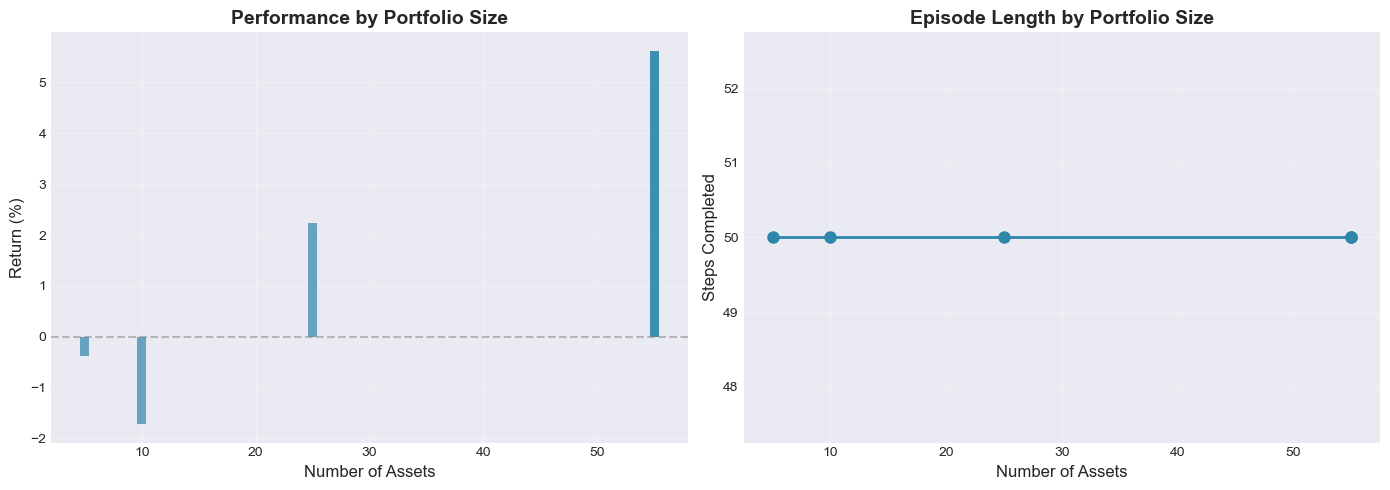

✅ Visualization saved


In [59]:
# ============================================================================
# CELL 11: Visualize Test Results
# ============================================================================

if results:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    # Returns by portfolio size
    sizes = [r['num_assets'] for r in results]
    returns = [r['return'] for r in results]
    
    ax1.bar(sizes, returns, color='#2E86AB', alpha=0.7)
    ax1.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
    ax1.set_xlabel('Number of Assets', fontsize=12)
    ax1.set_ylabel('Return (%)', fontsize=12)
    ax1.set_title('Performance by Portfolio Size', fontsize=14, fontweight='bold')
    ax1.grid(True, alpha=0.3)
    
    # Steps completed
    steps = [r['steps'] for r in results]
    ax2.plot(sizes, steps, marker='o', linewidth=2, markersize=8, color='#2E86AB')
    ax2.set_xlabel('Number of Assets', fontsize=12)
    ax2.set_ylabel('Steps Completed', fontsize=12)
    ax2.set_title('Episode Length by Portfolio Size', fontsize=14, fontweight='bold')
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(os.path.join(CONFIG['model_dir'], 'validation_results.png'), dpi=150, bbox_inches='tight')
    plt.show()
    
    print("✅ Visualization saved")


In [60]:
# ============================================================================
# CELL 12: Training Summary
# ============================================================================

print("\n" + "=" * 80)
print("🎉 TRAINING COMPLETE - FINAL SUMMARY")
print("=" * 80)
print("\n📊 Model Details:")
print(f"   Name: {CONFIG['model_name']}")
print(f"   Path: {model_path}.zip")
print(f"   Training Assets: {len(CONFIG['tickers'])}")
print(f"   Max Supported: {CONFIG['max_assets']}")
print(f"\n🎯 Key Features:")
print("   ✅ Dynamic portfolio support (3-100 assets)")
print("   ✅ Padding-based architecture")
print("   ✅ No retraining needed")
print("   ✅ Production-ready for web apps")
print(f"\n📁 Output Files:")
print(f"   ✅ {model_path}.zip")
print(f"   ✅ {CONFIG['model_dir']}/training_config.json")
print(f"   ✅ {CONFIG['model_dir']}/ppo_dynamic_checkpoint_*.zip")
print(f"   ✅ {CONFIG['model_dir']}/validation_results.png")
print(f"\n🚀 Next Steps:")
print("   1. Test with paper trading notebook")
print("   2. Deploy to Streamlit web app")
print("   3. Try different asset combinations")
print("\n" + "=" * 80)



🎉 TRAINING COMPLETE - FINAL SUMMARY

📊 Model Details:
   Name: ppo_dynamic_portfolio_padded
   Path: models/ppo_dynamic_portfolio_padded.zip
   Training Assets: 55
   Max Supported: 100

🎯 Key Features:
   ✅ Dynamic portfolio support (3-100 assets)
   ✅ Padding-based architecture
   ✅ No retraining needed
   ✅ Production-ready for web apps

📁 Output Files:
   ✅ models/ppo_dynamic_portfolio_padded.zip
   ✅ models/training_config.json
   ✅ models/ppo_dynamic_checkpoint_*.zip
   ✅ models/validation_results.png

🚀 Next Steps:
   1. Test with paper trading notebook
   2. Deploy to Streamlit web app
   3. Try different asset combinations

